# Testing out PHE (Partially Homomorphic Encryption) with the Deepface Framework

In [2]:
# importing necessary libraries
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from lightphe import LightPHE
from deepface import DeepFace
import pytest

In [3]:
os.makedirs("test_images", exist_ok=True)
os.makedirs("keys", exist_ok=True)

# Define paths for key files
private_key_path = "keys/private_key.txt"
public_key_path = "keys/public_key.txt"


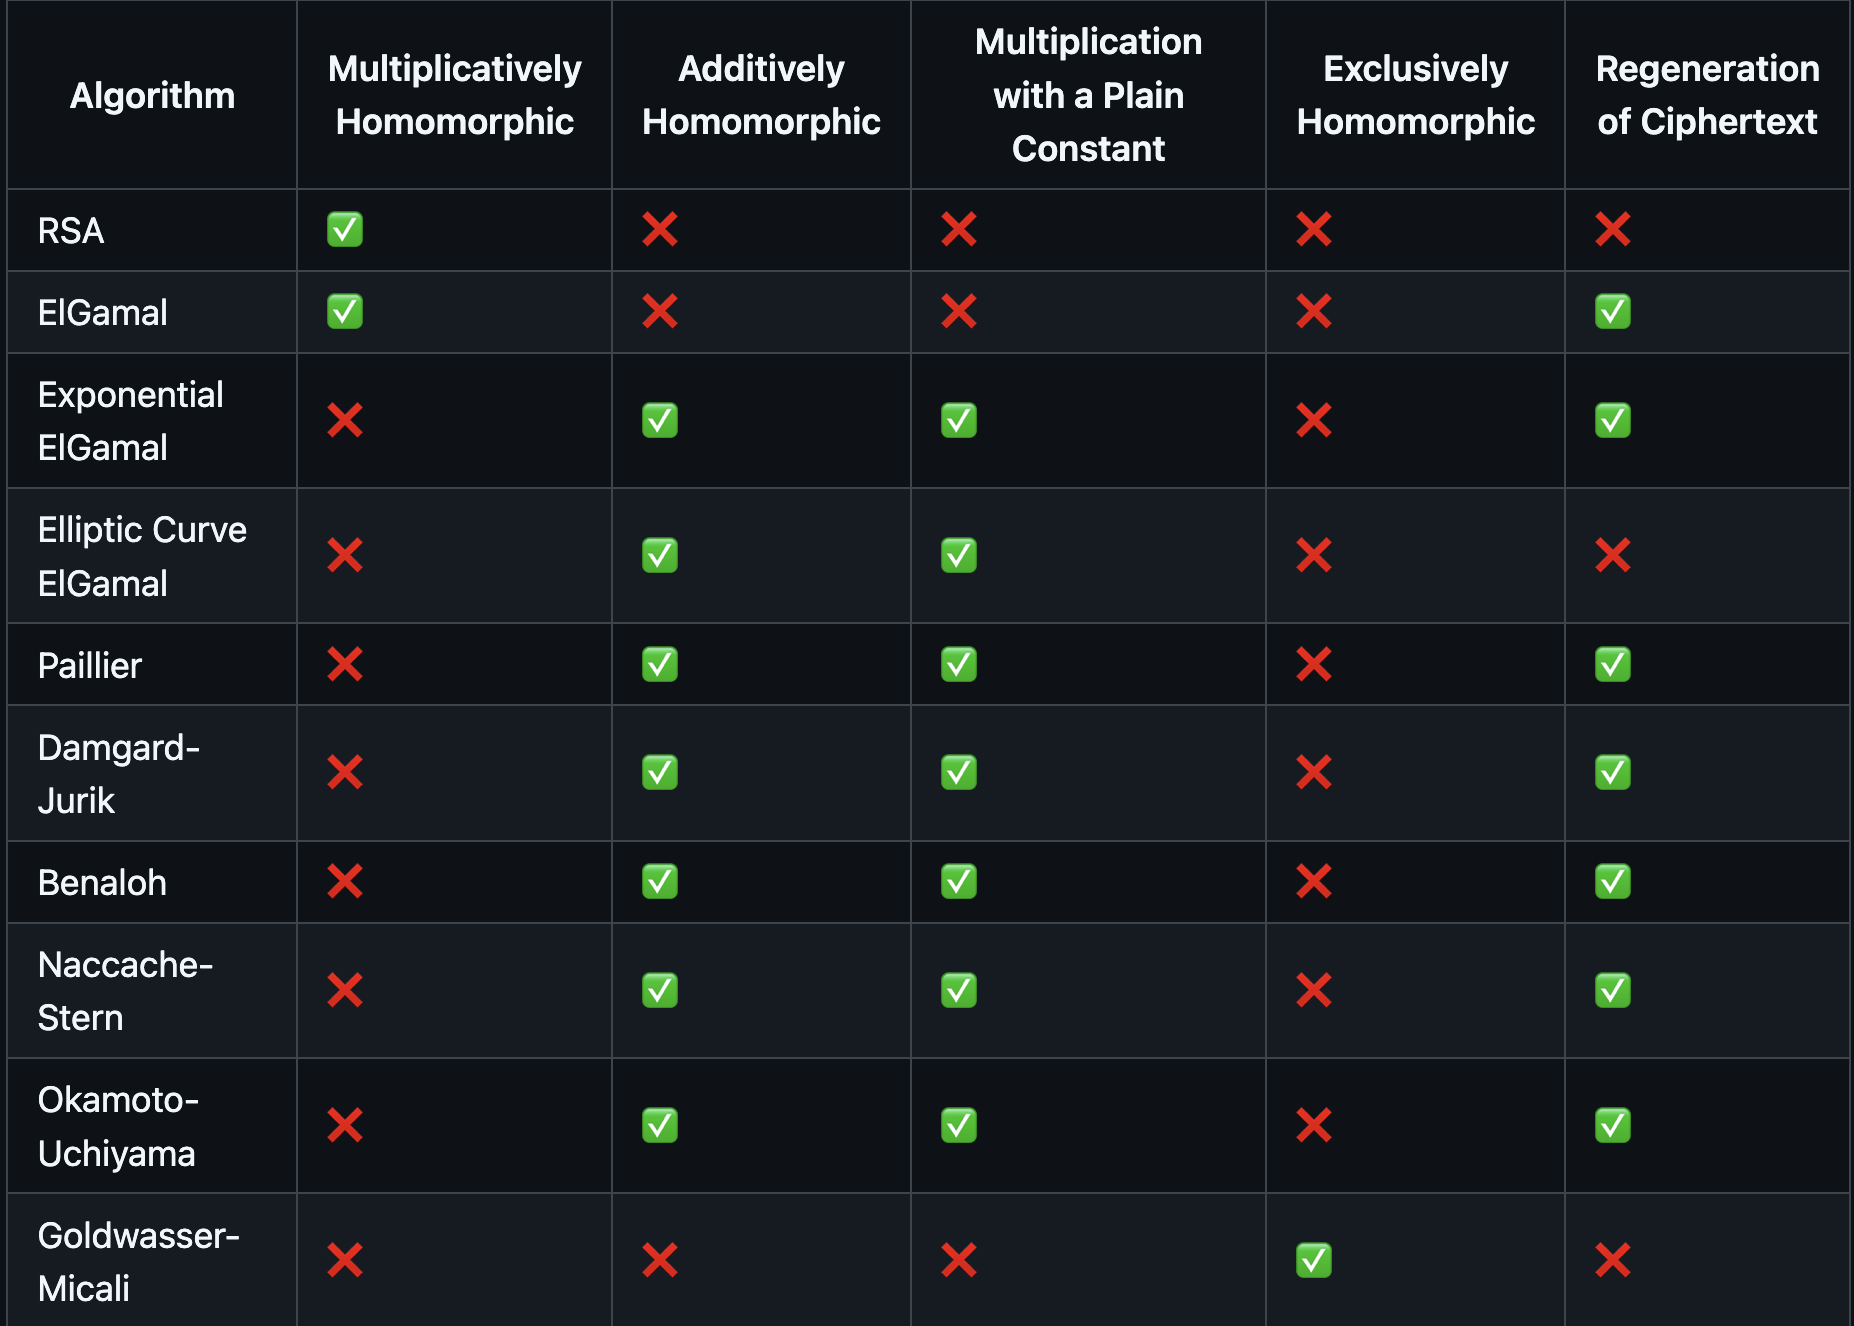

In [7]:
algorithms = [
  "Exponential-ElGamal",
  "Paillier",
  "Damgard-Jurik",
  "Okamoto-Uchiyama",
  "Benaloh",
  "Naccache-Stern",
]


print("Setting up client side with private key...")

# Initialize the homomorphic cryptosystem
example_cs = LightPHE(algorithm_name="Exponential-ElGamal", precision=19)

# Export the keys, the client has two set of keys: private and public
if keys := os.path.exists(private_key_path) and os.path.exists(public_key_path):
    print("Keys already exist, skipping export.")
    client_cs = LightPHE(algorithm_name="Exponential-ElGamal", precision=19, key_file=private_key_path)
    server_cs = LightPHE(algorithm_name="Exponential-ElGamal", precision=19, key_file=public_key_path)
else: 
    example_cs.export_keys(private_key_path, public=False)
    example_cs.export_keys(public_key_path, public=True)

    client_cs = LightPHE(algorithm_name="Exponential-ElGamal", precision=19, key_file=private_key_path)
    server_cs = LightPHE(algorithm_name="Exponential-ElGamal", precision=19, key_file=public_key_path)




Setting up client side with private key...
Keys already exist, skipping export.
25-07-21 16:12:44 - private-public key pair is restored from keys/private_key.txt
25-07-21 16:12:44 - public key is restored from keys/public_key.txt


 ### This means it is possible to multiply the corresponding dimension values of the encrypted vector from the client side with the plain vector from the cloud side element-wisely. The result will be a set of encrypted values for each dimension. Finally, you can sum the encrypted dimensions of this new encrypted vector – because we adopted additively homomorphic encryption algorithm – which gives you the encrypted cosine similarity. This approach allows you to compute cosine similarity securely while maintaining privacy.

 ### LightPHE supports several additively homomorphic encryption algorithms, including Paillier, Damgard-Jurik, Benaloh, Naccache-Stern, Okamoto-Uchiyama, Exponential ElGamal and Elliptic Curve ElGamal. However, Benaloh and Naccache-Stern are considered experimental, as they encounter issues when generating keys for longer bit lengths. Additionally, Exponential ElGamal relies on solving the discrete logarithm problem, while Elliptic Curve ElGamal requires solving the elliptic curve discrete logarithm problem during decryption. Due to these computational challenges, both are also classified as experimental and are not suitable for practical applications. In summary, to encrypt vector embeddings for encrypted vector similarity search, you should use Paillier, Damgard-Jurik, or Okamoto-Uchiyama, as they are the most practical choices.


Processing face embeddings...


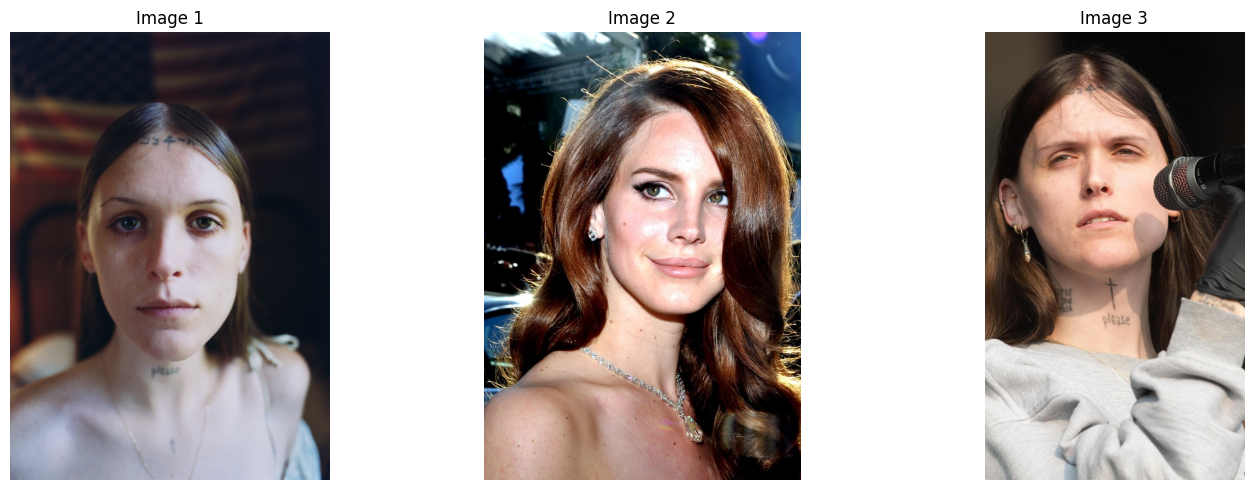

In [4]:
# Part 3: Testing with face embeddings

print("\nProcessing face embeddings...")
def download_sample_images():
    import requests
    
    image_urls = {
        "img1.jpg": "https://djwp.s3.amazonaws.com/wp-content/uploads/2022/05/16143651/document-ethel-3.jpg",
        "img2.jpg": "https://upload.wikimedia.org/wikipedia/commons/7/71/Lana_Del_Rey_Cannes_2012.jpg",
        "img3.jpg": "https://seatgeekimages.com/performers-landscape/ethel-cain-2c11be/798453/1100x1900.jpg?auto=webp&width=3840&quality=75"
    }
    
    for filename, url in image_urls.items():
        filepath = os.path.join("test_images", filename)
        if not os.path.exists(filepath):
            print(f"Downloading {filename}...")
            response = requests.get(url)
            with open(filepath, 'wb') as f:
                f.write(response.content)
            print(f"Downloaded {filename}")

download_sample_images()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, img_file in enumerate(["img1.jpg", "img2.jpg", "img3.jpg"]):
    img_path = os.path.join("test_images", img_file)
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()


In [45]:
# generating face embeddings with L2 normalization and MinMax scaling
import numpy as np
from sklearn.preprocessing import normalize, MinMaxScaler
from deepface import DeepFace
FIXED_POINT_FACTOR = 10**6 # This means 6 decimal places of precision

try:
    ethel1_embedding = DeepFace.represent(os.path.join("test_images", "img1.jpg"), model_name="VGG-Face", detector_backend="yunet")[0]["embedding"]
    ethel2_embedding = DeepFace.represent(os.path.join("test_images", "img3.jpg"), model_name="VGG-Face", detector_backend="yunet")[0]["embedding"]
    lana_embedding = DeepFace.represent(os.path.join("test_images", "img2.jpg"), model_name="VGG-Face", detector_backend="yunet")[0]["embedding"]
    # webcam_embedding = DeepFace.represent(os.path.join("test_images", "webcam_capture.jpg"), model_name="VGG-Face", detector_backend="yunet")[0]["embedding"]
    # selfie_embedding = DeepFace.represent(os.path.join("test_images", "selfie.jpg"), model_name="VGG-Face", detector_backend="yunet")[0]["embedding"]
    # selfie_embedding = DeepFace.represent(os.path.join("test_images", "portrait.JPG"), model_name="VGG-Face", detector_backend="yunet")[0]["embedding"]



    print("Face embeddings generated and normalized successfully.")
    print(f"Ethel1 embedding: min={min(ethel1_embedding)}, max={max(ethel1_embedding)}")
    print(f"ethel2 embedding: min={min(ethel2_embedding)}, max={max(ethel2_embedding)}")
    print(f"Lana embedding: min={min(lana_embedding)}, max={max(lana_embedding)}")
    # print(f"Webcam embedding: min={min(webcam_embedding)}, max={max(webcam_embedding)}")
    # print(f"Selfie embedding: min={min(selfie_embedding)}, max={max(selfie_embedding)}")

except Exception as e:
    print("Error in generating face embeddings. Ensure DeepFace is installed and configured correctly.")

Face embeddings generated and normalized successfully.
Ethel1 embedding: min=0.0, max=0.21498007632184607
ethel2 embedding: min=0.0, max=0.19596919503034896
Lana embedding: min=0.0, max=0.19571776377411287


In [52]:

ethel1_encrypted = client_cs.encrypt(ethel1_embedding.tolist())
ethel2_encrypted = client_cs.encrypt(ethel2_embedding.tolist())
lana_encrypted = client_cs.encrypt(lana_embedding.tolist())


Encrypting tensors: 100%|██████████| 512/512 [00:03<00:00, 159.78it/s]


In [9]:
import numpy as np
import os
import time
import sys
from deepface import DeepFace
from lightphe import LightPHE
import json # Import for JSON output

EMBEDDING_MODEL_NAME = "VGG-Face"
DETECTOR_BACKEND = "yunet"
EMBEDDING_PROCESSING_SIZE = 4096 

IMG_DIR = "test_images"
IMG_PATH_ETHEL1 = os.path.join(IMG_DIR, "img1.jpg")
IMG_PATH_ETHEL2 = os.path.join(IMG_DIR, "img3.jpg")
IMG_PATH_LANA = os.path.join(IMG_DIR, "img2.jpg")

KEYS_DIR = "phe_keys"
os.makedirs(KEYS_DIR, exist_ok=True)


def get_object_size_in_mb(obj):
    """Calculates the size of a Python object in MB."""
    return sys.getsizeof(obj) / (1024 * 1024)

def run_benchmark():
    # Store results for all precision levels and algorithms
    all_results = []

    print("--- Starting Embedding Generation (Plaintext Baseline) ---")
    os.makedirs(IMG_DIR, exist_ok=True)

    ethel1_embedding = DeepFace.represent(IMG_PATH_ETHEL1, model_name=EMBEDDING_MODEL_NAME, detector_backend=DETECTOR_BACKEND)[0]["embedding"]
    ethel2_embedding = DeepFace.represent(IMG_PATH_ETHEL2, model_name=EMBEDDING_MODEL_NAME, detector_backend=DETECTOR_BACKEND)[0]["embedding"]
    lana_embedding = DeepFace.represent(IMG_PATH_LANA, model_name=EMBEDDING_MODEL_NAME, detector_backend=DETECTOR_BACKEND)[0]["embedding"]

    if ethel1_embedding is None or ethel2_embedding is None or lana_embedding is None:
        print("Error: Could not generate all embeddings. Please check image paths and DeepFace setup.")
        return

    plain_dot_prod_ethel1_ethel2_full = np.dot(ethel1_embedding, ethel2_embedding)
    plain_dot_prod_ethel1_lana_full = np.dot(ethel1_embedding, lana_embedding)
    print(f"Plaintext Dot Product (Ethel1 vs Ethel2 - Full): {plain_dot_prod_ethel1_ethel2_full:.6f}")
    print(f"Plaintext Dot Product (Ethel1 vs Lana - Full): {plain_dot_prod_ethel1_lana_full:.6f}")


    algorithms = [
      "Paillier",
      "Damgard-Jurik",
      "Okamoto-Uchiyama",
      "Naccache-Stern",
    ]

    # --- Loop through precision values from 1 to 17 ---
    for precision_val in range(1, 18):
        print(f"\n===== Running Benchmarks for Precision: {precision_val} =====")
        
        # This will be the DEFAULT_PRECISION for the current iteration
        current_precision = precision_val 

        for algo_name in algorithms:
            print(f"\n--- Benchmarking {algo_name} with Precision {current_precision} ---")
            # Initialize a dictionary to store results for the current algorithm and precision
            current_algo_results = {
                "Precision": current_precision, # Add precision to results
                "Algorithm": algo_name,
                "Encryption Time (s)": "N/A", 
                "Dot Product Calculation Time (s)": "N/A", 
                "Decryption Time (s)": "N/A", 
                "Ciphertext Size (MB/emb)": "N/A", 
                "Loss (Ethel1 vs Ethel2)": "N/A",
                "Loss (Ethel1 vs Lana)": "N/A",
                "Plaintext Dot Product 1-2": plain_dot_prod_ethel1_ethel2_full,
                "Decrypted Dot Product 1-2": "N/A",
                "Plaintext Dot Product 1-L": plain_dot_prod_ethel1_lana_full,
                "Decrypted Dot Product 1-L": "N/A",
                "Error": None 
            }

            try:
                # Key generation will now use the current_precision
                private_key_path = os.path.join(KEYS_DIR, f"{algo_name.lower().replace('-', '_')}_precision{current_precision}_private_key.txt")
                public_key_path = os.path.join(KEYS_DIR, f"{algo_name.lower().replace('-', '_')}_precision{current_precision}_public_key.txt")
                
                if not os.path.exists(private_key_path) or not os.path.exists(public_key_path):
                    print(f"Keys for {algo_name} with precision {current_precision} not found. Generating new keys...")
                    # Pass current_precision to LightPHE constructor
                    example_cs = LightPHE(algorithm_name=algo_name, precision=current_precision)
                    example_cs.export_keys(private_key_path, public=False)
                    example_cs.export_keys(public_key_path, public=True)
                    print(f"Keys for {algo_name} with precision {current_precision} generated and saved.")
                else:
                    print(f"Keys for {algo_name} with precision {current_precision} exist. Proceeding to load.")

                # Load keys with current_precision
                client_cs = LightPHE(algorithm_name=algo_name, precision=current_precision, key_file=private_key_path)
                server_cs = LightPHE(algorithm_name=algo_name, precision=current_precision, key_file=public_key_path)

                # --- Encryption ---
                print("  Starting encryption for embeddings...")
                start_time_enc = time.time()
                encrypted_ethel1 = server_cs.encrypt(ethel1_embedding)
                encrypted_ethel2 = server_cs.encrypt(ethel2_embedding)
                encrypted_lana = server_cs.encrypt(lana_embedding)
                end_time_enc = time.time()
                current_algo_results["Encryption Time (s)"] = (end_time_enc - start_time_enc) / 3

                print(f"Encrypted Ethel1 embedding size: {get_object_size_in_mb(encrypted_ethel1):.6f} MB")
                print(f"Encrypted Ethel2 embedding size: {get_object_size_in_mb(encrypted_ethel2):.6f} MB")     
                print(f"Encrypted Lana embedding size: {get_object_size_in_mb(encrypted_lana):.6f} MB")
                current_algo_results["Ciphertext Size (MB/emb)"] = get_object_size_in_mb(encrypted_ethel1)


                # --- Calculate dot products ---
                start_time_dot_prod = time.time()
                encrypted_cosine_ethel1_ethel2 = encrypted_ethel2 @ ethel1_embedding
                encrypted_cosine_ethel1_lana = encrypted_lana @ ethel1_embedding
                end_time_dot_prod = time.time()
                current_algo_results["Dot Product Calculation Time (s)"] = (end_time_dot_prod - start_time_dot_prod)


                # --- Decrypt results ---
                start_time_dec = time.time()
                decrypted_cosine_ethel1_ethel2 = client_cs.decrypt(encrypted_cosine_ethel1_ethel2)[0]
                decrypted_cosine_ethel1_lana = client_cs.decrypt(encrypted_cosine_ethel1_lana)[0]
                end_time_dec = time.time()
                current_algo_results["Decryption Time (s)"] = (end_time_dec - start_time_dec)

                # --- Compare with plaintext result (Loss) ---
                loss_cosine_ethel = np.abs(plain_dot_prod_ethel1_ethel2_full - decrypted_cosine_ethel1_ethel2)
                loss_cosine_lana = np.abs(plain_dot_prod_ethel1_lana_full - decrypted_cosine_ethel1_lana)
                current_algo_results["Loss (Ethel1 vs Ethel2)"] = loss_cosine_ethel
                current_algo_results["Loss (Ethel1 vs Lana)"] = loss_cosine_lana
                current_algo_results["Decrypted Dot Product 1-2"] = decrypted_cosine_ethel1_ethel2
                current_algo_results["Decrypted Dot Product 1-L"] = decrypted_cosine_ethel1_lana


                print(f"Decrypted Dot Product (Ethel1 vs Ethel2 - Full): {decrypted_cosine_ethel1_ethel2:.6f}")
                print(f"Decrypted Dot Product (Ethel1 vs Lana - Full): {decrypted_cosine_ethel1_lana:.6f}")
                print(f"Loss (Ethel1 vs Ethel2 - Full): {loss_cosine_ethel:.6f}")
                print(f"Loss (Ethel1 vs Lana - Full): {loss_cosine_lana:.6f}")

            except Exception as e:
                print(f"Error for {algo_name} with precision {current_precision}: {e}")
                current_algo_results["Error"] = str(e)
            finally:
                all_results.append(current_algo_results) # Append to the overall results list
    
    print("\n--- Full Benchmark Results Summary ---")
    # For a large number of results, printing all of them might be too verbose.
    # You might want to remove this loop or print a summary.
    # for res in all_results:
    #     print(res)

    # Save all results to a JSON file
    results_file_sweep = "phe_benchmark_precision_sweep_results.json"
    try:
        with open(results_file_sweep, 'w') as f:
            json.dump(all_results, f, indent=4)
        print(f"\nAll benchmark results (precision sweep) saved to {results_file_sweep}")
    except Exception as e:
        print(f"Error saving results to JSON: {e}")

    # Optional: Display with pandas if installed
    try:
        import pandas as pd
        df_full = pd.DataFrame(all_results)
        print("\n--- Full Benchmark Results DataFrame ---")
        # print(df_full.to_string()) # This can be very long for many results
        print(df_full.head()) # Print just the head for brevity
    except ImportError:
        print("\nInstall pandas (pip install pandas) for better results visualization.")

if __name__ == "__main__":
    run_benchmark()

--- Starting Embedding Generation (Plaintext Baseline) ---
Plaintext Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Plaintext Dot Product (Ethel1 vs Lana - Full): 0.115143

===== Running Benchmarks for Precision: 1 =====

--- Benchmarking Paillier with Precision 1 ---
Keys for Paillier with precision 1 not found. Generating new keys...
25-07-21 20:17:09 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Paillier with precision 1 generated and saved.
25-07-21 20:17:09 - private-public key pair is restored from phe_keys/paillier_precision1_private_key.txt
25-07-21 20:17:09 - public key is restored from phe_keys/paillier_precision1_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:01<00:00, 2197.95it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.050000
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.000000
Loss (Ethel1 vs Ethel2 - Full): 0.489833
Loss (Ethel1 vs Lana - Full): 0.115143

--- Benchmarking Damgard-Jurik with Precision 1 ---
Keys for Damgard-Jurik with precision 1 not found. Generating new keys...
25-07-21 20:17:17 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Damgard-Jurik with precision 1 generated and saved.
25-07-21 20:17:17 - private-public key pair is restored from phe_keys/damgard_jurik_precision1_private_key.txt
25-07-21 20:17:17 - public key is restored from phe_keys/damgard_jurik_precision1_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:03<00:00, 1202.40it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.050000
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.000000
Loss (Ethel1 vs Ethel2 - Full): 0.489833
Loss (Ethel1 vs Lana - Full): 0.115143

--- Benchmarking Okamoto-Uchiyama with Precision 1 ---
Keys for Okamoto-Uchiyama with precision 1 not found. Generating new keys...
25-07-21 20:17:29 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Okamoto-Uchiyama with precision 1 generated and saved.
25-07-21 20:17:29 - private-public key pair is restored from phe_keys/okamoto_uchiyama_precision1_private_key.txt
25-07-21 20:17:29 - public key is restored from phe_keys/okamoto_uchiyama_precision1_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:01<00:00, 2264.65it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.050000
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.000000
Loss (Ethel1 vs Ethel2 - Full): 0.489833
Loss (Ethel1 vs Lana - Full): 0.115143

--- Benchmarking Naccache-Stern with Precision 1 ---
Keys for Naccache-Stern with precision 1 not found. Generating new keys...
25-07-21 20:17:36 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Naccache-Stern with precision 1 generated and saved.
25-07-21 20:17:36 - private-public key pair is restored from phe_keys/naccache_stern_precision1_private_key.txt
25-07-21 20:17:36 - public key is restored from phe_keys/naccache_stern_precision1_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:00<00:00, 8117.08it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.050000
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.000000
Loss (Ethel1 vs Ethel2 - Full): 0.489833
Loss (Ethel1 vs Lana - Full): 0.115143

===== Running Benchmarks for Precision: 2 =====

--- Benchmarking Paillier with Precision 2 ---
Keys for Paillier with precision 2 not found. Generating new keys...
25-07-21 20:17:39 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Paillier with precision 2 generated and saved.
25-07-21 20:17:39 - private-public key pair is restored from phe_keys/paillier_precision2_private_key.txt
25-07-21 20:17:39 - public key is restored from phe_keys/paillier_precision2_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:01<00:00, 2154.48it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.440000
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.082400
Loss (Ethel1 vs Ethel2 - Full): 0.099833
Loss (Ethel1 vs Lana - Full): 0.032743

--- Benchmarking Damgard-Jurik with Precision 2 ---
Keys for Damgard-Jurik with precision 2 not found. Generating new keys...
25-07-21 20:17:47 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Damgard-Jurik with precision 2 generated and saved.
25-07-21 20:17:47 - private-public key pair is restored from phe_keys/damgard_jurik_precision2_private_key.txt
25-07-21 20:17:47 - public key is restored from phe_keys/damgard_jurik_precision2_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:04<00:00, 1003.68it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.440000
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.082400
Loss (Ethel1 vs Ethel2 - Full): 0.099833
Loss (Ethel1 vs Lana - Full): 0.032743

--- Benchmarking Okamoto-Uchiyama with Precision 2 ---
Keys for Okamoto-Uchiyama with precision 2 not found. Generating new keys...
25-07-21 20:18:00 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Okamoto-Uchiyama with precision 2 generated and saved.
25-07-21 20:18:00 - private-public key pair is restored from phe_keys/okamoto_uchiyama_precision2_private_key.txt
25-07-21 20:18:00 - public key is restored from phe_keys/okamoto_uchiyama_precision2_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:01<00:00, 2307.44it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.440000
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.082400
Loss (Ethel1 vs Ethel2 - Full): 0.099833
Loss (Ethel1 vs Lana - Full): 0.032743

--- Benchmarking Naccache-Stern with Precision 2 ---
Keys for Naccache-Stern with precision 2 not found. Generating new keys...
25-07-21 20:18:08 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Naccache-Stern with precision 2 generated and saved.
25-07-21 20:18:08 - private-public key pair is restored from phe_keys/naccache_stern_precision2_private_key.txt
25-07-21 20:18:08 - public key is restored from phe_keys/naccache_stern_precision2_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:00<00:00, 6540.23it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.440000
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.082400
Loss (Ethel1 vs Ethel2 - Full): 0.099833
Loss (Ethel1 vs Lana - Full): 0.032743

===== Running Benchmarks for Precision: 3 =====

--- Benchmarking Paillier with Precision 3 ---
Keys for Paillier with precision 3 not found. Generating new keys...
25-07-21 20:18:11 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Paillier with precision 3 generated and saved.
25-07-21 20:18:11 - private-public key pair is restored from phe_keys/paillier_precision3_private_key.txt
25-07-21 20:18:11 - public key is restored from phe_keys/paillier_precision3_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:02<00:00, 1509.69it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.529409
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.111850
Loss (Ethel1 vs Ethel2 - Full): 0.010424
Loss (Ethel1 vs Lana - Full): 0.003293

--- Benchmarking Damgard-Jurik with Precision 3 ---
Keys for Damgard-Jurik with precision 3 not found. Generating new keys...
25-07-21 20:18:21 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Damgard-Jurik with precision 3 generated and saved.
25-07-21 20:18:21 - private-public key pair is restored from phe_keys/damgard_jurik_precision3_private_key.txt
25-07-21 20:18:21 - public key is restored from phe_keys/damgard_jurik_precision3_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:04<00:00, 831.20it/s] 


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.529409
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.111850
Loss (Ethel1 vs Ethel2 - Full): 0.010424
Loss (Ethel1 vs Lana - Full): 0.003293

--- Benchmarking Okamoto-Uchiyama with Precision 3 ---
Keys for Okamoto-Uchiyama with precision 3 not found. Generating new keys...
25-07-21 20:18:37 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Okamoto-Uchiyama with precision 3 generated and saved.
25-07-21 20:18:37 - private-public key pair is restored from phe_keys/okamoto_uchiyama_precision3_private_key.txt
25-07-21 20:18:37 - public key is restored from phe_keys/okamoto_uchiyama_precision3_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:02<00:00, 2041.55it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.529409
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.111850
Loss (Ethel1 vs Ethel2 - Full): 0.010424
Loss (Ethel1 vs Lana - Full): 0.003293

--- Benchmarking Naccache-Stern with Precision 3 ---
Keys for Naccache-Stern with precision 3 not found. Generating new keys...
25-07-21 20:18:45 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Naccache-Stern with precision 3 generated and saved.
25-07-21 20:18:45 - private-public key pair is restored from phe_keys/naccache_stern_precision3_private_key.txt
25-07-21 20:18:45 - public key is restored from phe_keys/naccache_stern_precision3_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:00<00:00, 5196.87it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.080684
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.477512
Loss (Ethel1 vs Ethel2 - Full): 0.459150
Loss (Ethel1 vs Lana - Full): 0.362369

===== Running Benchmarks for Precision: 4 =====

--- Benchmarking Paillier with Precision 4 ---
Keys for Paillier with precision 4 not found. Generating new keys...
25-07-21 20:18:49 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Paillier with precision 4 generated and saved.
25-07-21 20:18:49 - private-public key pair is restored from phe_keys/paillier_precision4_private_key.txt
25-07-21 20:18:49 - public key is restored from phe_keys/paillier_precision4_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:02<00:00, 1429.40it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.538835
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.114838
Loss (Ethel1 vs Ethel2 - Full): 0.000998
Loss (Ethel1 vs Lana - Full): 0.000305

--- Benchmarking Damgard-Jurik with Precision 4 ---
Keys for Damgard-Jurik with precision 4 not found. Generating new keys...
25-07-21 20:18:59 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Damgard-Jurik with precision 4 generated and saved.
25-07-21 20:18:59 - private-public key pair is restored from phe_keys/damgard_jurik_precision4_private_key.txt
25-07-21 20:18:59 - public key is restored from phe_keys/damgard_jurik_precision4_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:04<00:00, 903.08it/s] 


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.538835
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.114838
Loss (Ethel1 vs Ethel2 - Full): 0.000998
Loss (Ethel1 vs Lana - Full): 0.000305

--- Benchmarking Okamoto-Uchiyama with Precision 4 ---
Keys for Okamoto-Uchiyama with precision 4 not found. Generating new keys...
25-07-21 20:19:15 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Okamoto-Uchiyama with precision 4 generated and saved.
25-07-21 20:19:15 - private-public key pair is restored from phe_keys/okamoto_uchiyama_precision4_private_key.txt
25-07-21 20:19:15 - public key is restored from phe_keys/okamoto_uchiyama_precision4_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:02<00:00, 1822.48it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.538835
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.114838
Loss (Ethel1 vs Ethel2 - Full): 0.000998
Loss (Ethel1 vs Lana - Full): 0.000305

--- Benchmarking Naccache-Stern with Precision 4 ---
Keys for Naccache-Stern with precision 4 not found. Generating new keys...
25-07-21 20:19:24 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Naccache-Stern with precision 4 generated and saved.
25-07-21 20:19:24 - private-public key pair is restored from phe_keys/naccache_stern_precision4_private_key.txt
25-07-21 20:19:24 - public key is restored from phe_keys/naccache_stern_precision4_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:00<00:00, 4391.76it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.126634
Decrypted Dot Product (Ethel1 vs Lana - Full): 1.293290
Loss (Ethel1 vs Ethel2 - Full): 0.413199
Loss (Ethel1 vs Lana - Full): 1.178147

===== Running Benchmarks for Precision: 5 =====

--- Benchmarking Paillier with Precision 5 ---
Keys for Paillier with precision 5 not found. Generating new keys...
25-07-21 20:19:29 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Paillier with precision 5 generated and saved.
25-07-21 20:19:29 - private-public key pair is restored from phe_keys/paillier_precision5_private_key.txt
25-07-21 20:19:29 - public key is restored from phe_keys/paillier_precision5_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:02<00:00, 1794.42it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539730
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115110
Loss (Ethel1 vs Ethel2 - Full): 0.000104
Loss (Ethel1 vs Lana - Full): 0.000033

--- Benchmarking Damgard-Jurik with Precision 5 ---
Keys for Damgard-Jurik with precision 5 not found. Generating new keys...
25-07-21 20:19:38 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Damgard-Jurik with precision 5 generated and saved.
25-07-21 20:19:38 - private-public key pair is restored from phe_keys/damgard_jurik_precision5_private_key.txt
25-07-21 20:19:38 - public key is restored from phe_keys/damgard_jurik_precision5_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:03<00:00, 1065.29it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539730
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115110
Loss (Ethel1 vs Ethel2 - Full): 0.000104
Loss (Ethel1 vs Lana - Full): 0.000033

--- Benchmarking Okamoto-Uchiyama with Precision 5 ---
Keys for Okamoto-Uchiyama with precision 5 not found. Generating new keys...
25-07-21 20:19:54 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Okamoto-Uchiyama with precision 5 generated and saved.
25-07-21 20:19:54 - private-public key pair is restored from phe_keys/okamoto_uchiyama_precision5_private_key.txt
25-07-21 20:19:54 - public key is restored from phe_keys/okamoto_uchiyama_precision5_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:01<00:00, 2238.39it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539730
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115110
Loss (Ethel1 vs Ethel2 - Full): 0.000104
Loss (Ethel1 vs Lana - Full): 0.000033

--- Benchmarking Naccache-Stern with Precision 5 ---
Keys for Naccache-Stern with precision 5 not found. Generating new keys...
25-07-21 20:20:03 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Naccache-Stern with precision 5 generated and saved.
25-07-21 20:20:03 - private-public key pair is restored from phe_keys/naccache_stern_precision5_private_key.txt
25-07-21 20:20:03 - public key is restored from phe_keys/naccache_stern_precision5_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:00<00:00, 16503.62it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 1.410913
Decrypted Dot Product (Ethel1 vs Lana - Full): 1.179104
Loss (Ethel1 vs Ethel2 - Full): 0.871080
Loss (Ethel1 vs Lana - Full): 1.063961

===== Running Benchmarks for Precision: 6 =====

--- Benchmarking Paillier with Precision 6 ---
Keys for Paillier with precision 6 not found. Generating new keys...
25-07-21 20:20:07 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Paillier with precision 6 generated and saved.
25-07-21 20:20:07 - private-public key pair is restored from phe_keys/paillier_precision6_private_key.txt
25-07-21 20:20:07 - public key is restored from phe_keys/paillier_precision6_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:01<00:00, 2345.99it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539823
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115139
Loss (Ethel1 vs Ethel2 - Full): 0.000010
Loss (Ethel1 vs Lana - Full): 0.000003

--- Benchmarking Damgard-Jurik with Precision 6 ---
Keys for Damgard-Jurik with precision 6 not found. Generating new keys...
25-07-21 20:20:16 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Damgard-Jurik with precision 6 generated and saved.
25-07-21 20:20:16 - private-public key pair is restored from phe_keys/damgard_jurik_precision6_private_key.txt
25-07-21 20:20:16 - public key is restored from phe_keys/damgard_jurik_precision6_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:03<00:00, 1184.43it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539823
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115139
Loss (Ethel1 vs Ethel2 - Full): 0.000010
Loss (Ethel1 vs Lana - Full): 0.000003

--- Benchmarking Okamoto-Uchiyama with Precision 6 ---
Keys for Okamoto-Uchiyama with precision 6 not found. Generating new keys...
25-07-21 20:20:31 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Okamoto-Uchiyama with precision 6 generated and saved.
25-07-21 20:20:31 - private-public key pair is restored from phe_keys/okamoto_uchiyama_precision6_private_key.txt
25-07-21 20:20:31 - public key is restored from phe_keys/okamoto_uchiyama_precision6_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:01<00:00, 2611.69it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539823
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115139
Loss (Ethel1 vs Ethel2 - Full): 0.000010
Loss (Ethel1 vs Lana - Full): 0.000003

--- Benchmarking Naccache-Stern with Precision 6 ---
Keys for Naccache-Stern with precision 6 not found. Generating new keys...
25-07-21 20:20:40 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Naccache-Stern with precision 6 generated and saved.
25-07-21 20:20:40 - private-public key pair is restored from phe_keys/naccache_stern_precision6_private_key.txt
25-07-21 20:20:40 - public key is restored from phe_keys/naccache_stern_precision6_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:00<00:00, 26273.93it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.132337
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.689248
Loss (Ethel1 vs Ethel2 - Full): 0.407496
Loss (Ethel1 vs Lana - Full): 0.574105

===== Running Benchmarks for Precision: 7 =====

--- Benchmarking Paillier with Precision 7 ---
Keys for Paillier with precision 7 not found. Generating new keys...
25-07-21 20:20:44 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Paillier with precision 7 generated and saved.
25-07-21 20:20:44 - private-public key pair is restored from phe_keys/paillier_precision7_private_key.txt
25-07-21 20:20:44 - public key is restored from phe_keys/paillier_precision7_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:02<00:00, 1563.44it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539832
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115142
Loss (Ethel1 vs Ethel2 - Full): 0.000001
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Damgard-Jurik with Precision 7 ---
Keys for Damgard-Jurik with precision 7 not found. Generating new keys...
25-07-21 20:20:54 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Damgard-Jurik with precision 7 generated and saved.
25-07-21 20:20:54 - private-public key pair is restored from phe_keys/damgard_jurik_precision7_private_key.txt
25-07-21 20:20:54 - public key is restored from phe_keys/damgard_jurik_precision7_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:05<00:00, 706.55it/s] 


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539832
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115142
Loss (Ethel1 vs Ethel2 - Full): 0.000001
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Okamoto-Uchiyama with Precision 7 ---
Keys for Okamoto-Uchiyama with precision 7 not found. Generating new keys...
25-07-21 20:21:13 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Okamoto-Uchiyama with precision 7 generated and saved.
25-07-21 20:21:13 - private-public key pair is restored from phe_keys/okamoto_uchiyama_precision7_private_key.txt
25-07-21 20:21:13 - public key is restored from phe_keys/okamoto_uchiyama_precision7_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:01<00:00, 2685.86it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539832
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115142
Loss (Ethel1 vs Ethel2 - Full): 0.000001
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Naccache-Stern with Precision 7 ---
Keys for Naccache-Stern with precision 7 not found. Generating new keys...
25-07-21 20:21:21 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Naccache-Stern with precision 7 generated and saved.
25-07-21 20:21:21 - private-public key pair is restored from phe_keys/naccache_stern_precision7_private_key.txt
25-07-21 20:21:21 - public key is restored from phe_keys/naccache_stern_precision7_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:00<00:00, 4344.55it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 1.277034
Decrypted Dot Product (Ethel1 vs Lana - Full): 1.471776
Loss (Ethel1 vs Ethel2 - Full): 0.737200
Loss (Ethel1 vs Lana - Full): 1.356633

===== Running Benchmarks for Precision: 8 =====

--- Benchmarking Paillier with Precision 8 ---
Keys for Paillier with precision 8 not found. Generating new keys...
25-07-21 20:21:25 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Paillier with precision 8 generated and saved.
25-07-21 20:21:25 - private-public key pair is restored from phe_keys/paillier_precision8_private_key.txt
25-07-21 20:21:25 - public key is restored from phe_keys/paillier_precision8_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:02<00:00, 1804.45it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Damgard-Jurik with Precision 8 ---
Keys for Damgard-Jurik with precision 8 not found. Generating new keys...
25-07-21 20:21:35 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Damgard-Jurik with precision 8 generated and saved.
25-07-21 20:21:35 - private-public key pair is restored from phe_keys/damgard_jurik_precision8_private_key.txt
25-07-21 20:21:35 - public key is restored from phe_keys/damgard_jurik_precision8_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:04<00:00, 953.85it/s] 


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Okamoto-Uchiyama with Precision 8 ---
Keys for Okamoto-Uchiyama with precision 8 not found. Generating new keys...
25-07-21 20:21:52 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Okamoto-Uchiyama with precision 8 generated and saved.
25-07-21 20:21:52 - private-public key pair is restored from phe_keys/okamoto_uchiyama_precision8_private_key.txt
25-07-21 20:21:52 - public key is restored from phe_keys/okamoto_uchiyama_precision8_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:02<00:00, 1699.05it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Naccache-Stern with Precision 8 ---
Keys for Naccache-Stern with precision 8 not found. Generating new keys...
25-07-21 20:22:00 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Naccache-Stern with precision 8 generated and saved.
25-07-21 20:22:00 - private-public key pair is restored from phe_keys/naccache_stern_precision8_private_key.txt
25-07-21 20:22:00 - public key is restored from phe_keys/naccache_stern_precision8_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:00<00:00, 5783.27it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.973404
Decrypted Dot Product (Ethel1 vs Lana - Full): 1.181460
Loss (Ethel1 vs Ethel2 - Full): 0.433571
Loss (Ethel1 vs Lana - Full): 1.066317

===== Running Benchmarks for Precision: 9 =====

--- Benchmarking Paillier with Precision 9 ---
Keys for Paillier with precision 9 not found. Generating new keys...
25-07-21 20:22:03 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Paillier with precision 9 generated and saved.
25-07-21 20:22:03 - private-public key pair is restored from phe_keys/paillier_precision9_private_key.txt
25-07-21 20:22:03 - public key is restored from phe_keys/paillier_precision9_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:02<00:00, 1637.94it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Damgard-Jurik with Precision 9 ---
Keys for Damgard-Jurik with precision 9 not found. Generating new keys...
25-07-21 20:22:14 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Damgard-Jurik with precision 9 generated and saved.
25-07-21 20:22:14 - private-public key pair is restored from phe_keys/damgard_jurik_precision9_private_key.txt
25-07-21 20:22:14 - public key is restored from phe_keys/damgard_jurik_precision9_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:04<00:00, 914.70it/s] 


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Okamoto-Uchiyama with Precision 9 ---
Keys for Okamoto-Uchiyama with precision 9 not found. Generating new keys...
25-07-21 20:22:33 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Okamoto-Uchiyama with precision 9 generated and saved.
25-07-21 20:22:33 - private-public key pair is restored from phe_keys/okamoto_uchiyama_precision9_private_key.txt
25-07-21 20:22:33 - public key is restored from phe_keys/okamoto_uchiyama_precision9_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:02<00:00, 1511.04it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Naccache-Stern with Precision 9 ---
Keys for Naccache-Stern with precision 9 not found. Generating new keys...
25-07-21 20:22:43 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Naccache-Stern with precision 9 generated and saved.
25-07-21 20:22:43 - private-public key pair is restored from phe_keys/naccache_stern_precision9_private_key.txt
25-07-21 20:22:43 - public key is restored from phe_keys/naccache_stern_precision9_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:00<00:00, 6575.01it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 1.614497
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.922032
Loss (Ethel1 vs Ethel2 - Full): 1.074664
Loss (Ethel1 vs Lana - Full): 0.806889

===== Running Benchmarks for Precision: 10 =====

--- Benchmarking Paillier with Precision 10 ---
Keys for Paillier with precision 10 not found. Generating new keys...
25-07-21 20:22:46 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Paillier with precision 10 generated and saved.
25-07-21 20:22:46 - private-public key pair is restored from phe_keys/paillier_precision10_private_key.txt
25-07-21 20:22:46 - public key is restored from phe_keys/paillier_precision10_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:02<00:00, 1774.04it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Damgard-Jurik with Precision 10 ---
Keys for Damgard-Jurik with precision 10 not found. Generating new keys...
25-07-21 20:22:56 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Damgard-Jurik with precision 10 generated and saved.
25-07-21 20:22:56 - private-public key pair is restored from phe_keys/damgard_jurik_precision10_private_key.txt
25-07-21 20:22:56 - public key is restored from phe_keys/damgard_jurik_precision10_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:04<00:00, 951.92it/s] 


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Okamoto-Uchiyama with Precision 10 ---
Keys for Okamoto-Uchiyama with precision 10 not found. Generating new keys...
25-07-21 20:23:12 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Okamoto-Uchiyama with precision 10 generated and saved.
25-07-21 20:23:12 - private-public key pair is restored from phe_keys/okamoto_uchiyama_precision10_private_key.txt
25-07-21 20:23:12 - public key is restored from phe_keys/okamoto_uchiyama_precision10_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:01<00:00, 2107.54it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Naccache-Stern with Precision 10 ---
Keys for Naccache-Stern with precision 10 not found. Generating new keys...
25-07-21 20:23:19 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Naccache-Stern with precision 10 generated and saved.
25-07-21 20:23:19 - private-public key pair is restored from phe_keys/naccache_stern_precision10_private_key.txt
25-07-21 20:23:19 - public key is restored from phe_keys/naccache_stern_precision10_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:00<00:00, 6409.40it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.619474
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.809371
Loss (Ethel1 vs Ethel2 - Full): 0.079641
Loss (Ethel1 vs Lana - Full): 0.694228

===== Running Benchmarks for Precision: 11 =====

--- Benchmarking Paillier with Precision 11 ---
Keys for Paillier with precision 11 not found. Generating new keys...
25-07-21 20:23:23 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Paillier with precision 11 generated and saved.
25-07-21 20:23:23 - private-public key pair is restored from phe_keys/paillier_precision11_private_key.txt
25-07-21 20:23:23 - public key is restored from phe_keys/paillier_precision11_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:02<00:00, 1734.51it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Damgard-Jurik with Precision 11 ---
Keys for Damgard-Jurik with precision 11 not found. Generating new keys...
25-07-21 20:23:32 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Damgard-Jurik with precision 11 generated and saved.
25-07-21 20:23:32 - private-public key pair is restored from phe_keys/damgard_jurik_precision11_private_key.txt
25-07-21 20:23:32 - public key is restored from phe_keys/damgard_jurik_precision11_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:04<00:00, 981.82it/s] 


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Okamoto-Uchiyama with Precision 11 ---
Keys for Okamoto-Uchiyama with precision 11 not found. Generating new keys...
25-07-21 20:23:49 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Okamoto-Uchiyama with precision 11 generated and saved.
25-07-21 20:23:49 - private-public key pair is restored from phe_keys/okamoto_uchiyama_precision11_private_key.txt
25-07-21 20:23:49 - public key is restored from phe_keys/okamoto_uchiyama_precision11_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:02<00:00, 1516.19it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Naccache-Stern with Precision 11 ---
Keys for Naccache-Stern with precision 11 not found. Generating new keys...
25-07-21 20:23:59 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Naccache-Stern with precision 11 generated and saved.
25-07-21 20:23:59 - private-public key pair is restored from phe_keys/naccache_stern_precision11_private_key.txt
25-07-21 20:23:59 - public key is restored from phe_keys/naccache_stern_precision11_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:00<00:00, 5591.93it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.508110
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.585482
Loss (Ethel1 vs Ethel2 - Full): 0.031723
Loss (Ethel1 vs Lana - Full): 0.470339

===== Running Benchmarks for Precision: 12 =====

--- Benchmarking Paillier with Precision 12 ---
Keys for Paillier with precision 12 not found. Generating new keys...
25-07-21 20:24:02 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Paillier with precision 12 generated and saved.
25-07-21 20:24:02 - private-public key pair is restored from phe_keys/paillier_precision12_private_key.txt
25-07-21 20:24:02 - public key is restored from phe_keys/paillier_precision12_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:02<00:00, 1579.21it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Damgard-Jurik with Precision 12 ---
Keys for Damgard-Jurik with precision 12 not found. Generating new keys...
25-07-21 20:24:13 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Damgard-Jurik with precision 12 generated and saved.
25-07-21 20:24:13 - private-public key pair is restored from phe_keys/damgard_jurik_precision12_private_key.txt
25-07-21 20:24:13 - public key is restored from phe_keys/damgard_jurik_precision12_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:04<00:00, 917.09it/s] 


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Okamoto-Uchiyama with Precision 12 ---
Keys for Okamoto-Uchiyama with precision 12 not found. Generating new keys...
25-07-21 20:24:30 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Okamoto-Uchiyama with precision 12 generated and saved.
25-07-21 20:24:30 - private-public key pair is restored from phe_keys/okamoto_uchiyama_precision12_private_key.txt
25-07-21 20:24:30 - public key is restored from phe_keys/okamoto_uchiyama_precision12_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:02<00:00, 1884.54it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Naccache-Stern with Precision 12 ---
Keys for Naccache-Stern with precision 12 not found. Generating new keys...
25-07-21 20:24:39 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Naccache-Stern with precision 12 generated and saved.
25-07-21 20:24:39 - private-public key pair is restored from phe_keys/naccache_stern_precision12_private_key.txt
25-07-21 20:24:39 - public key is restored from phe_keys/naccache_stern_precision12_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:00<00:00, 5530.76it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 3.520819
Decrypted Dot Product (Ethel1 vs Lana - Full): 1.494325
Loss (Ethel1 vs Ethel2 - Full): 2.980986
Loss (Ethel1 vs Lana - Full): 1.379182

===== Running Benchmarks for Precision: 13 =====

--- Benchmarking Paillier with Precision 13 ---
Keys for Paillier with precision 13 not found. Generating new keys...
25-07-21 20:24:44 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Paillier with precision 13 generated and saved.
25-07-21 20:24:44 - private-public key pair is restored from phe_keys/paillier_precision13_private_key.txt
25-07-21 20:24:44 - public key is restored from phe_keys/paillier_precision13_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:02<00:00, 1554.92it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Damgard-Jurik with Precision 13 ---
Keys for Damgard-Jurik with precision 13 not found. Generating new keys...
25-07-21 20:24:53 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Damgard-Jurik with precision 13 generated and saved.
25-07-21 20:24:53 - private-public key pair is restored from phe_keys/damgard_jurik_precision13_private_key.txt
25-07-21 20:24:53 - public key is restored from phe_keys/damgard_jurik_precision13_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:05<00:00, 764.69it/s] 


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Okamoto-Uchiyama with Precision 13 ---
Keys for Okamoto-Uchiyama with precision 13 not found. Generating new keys...
25-07-21 20:25:12 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Okamoto-Uchiyama with precision 13 generated and saved.
25-07-21 20:25:12 - private-public key pair is restored from phe_keys/okamoto_uchiyama_precision13_private_key.txt
25-07-21 20:25:12 - public key is restored from phe_keys/okamoto_uchiyama_precision13_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:02<00:00, 1831.91it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Naccache-Stern with Precision 13 ---
Keys for Naccache-Stern with precision 13 not found. Generating new keys...
25-07-21 20:25:22 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Naccache-Stern with precision 13 generated and saved.
25-07-21 20:25:22 - private-public key pair is restored from phe_keys/naccache_stern_precision13_private_key.txt
25-07-21 20:25:22 - public key is restored from phe_keys/naccache_stern_precision13_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:00<00:00, 12236.65it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 13.193847
Decrypted Dot Product (Ethel1 vs Lana - Full): 8.698776
Loss (Ethel1 vs Ethel2 - Full): 12.654014
Loss (Ethel1 vs Lana - Full): 8.583633

===== Running Benchmarks for Precision: 14 =====

--- Benchmarking Paillier with Precision 14 ---
Keys for Paillier with precision 14 not found. Generating new keys...
25-07-21 20:25:25 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Paillier with precision 14 generated and saved.
25-07-21 20:25:25 - private-public key pair is restored from phe_keys/paillier_precision14_private_key.txt
25-07-21 20:25:25 - public key is restored from phe_keys/paillier_precision14_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:01<00:00, 2193.27it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Damgard-Jurik with Precision 14 ---
Keys for Damgard-Jurik with precision 14 not found. Generating new keys...
25-07-21 20:25:35 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Damgard-Jurik with precision 14 generated and saved.
25-07-21 20:25:35 - private-public key pair is restored from phe_keys/damgard_jurik_precision14_private_key.txt
25-07-21 20:25:35 - public key is restored from phe_keys/damgard_jurik_precision14_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:04<00:00, 827.19it/s] 


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Okamoto-Uchiyama with Precision 14 ---
Keys for Okamoto-Uchiyama with precision 14 not found. Generating new keys...
25-07-21 20:25:53 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Okamoto-Uchiyama with precision 14 generated and saved.
25-07-21 20:25:53 - private-public key pair is restored from phe_keys/okamoto_uchiyama_precision14_private_key.txt
25-07-21 20:25:53 - public key is restored from phe_keys/okamoto_uchiyama_precision14_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:01<00:00, 2242.15it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Naccache-Stern with Precision 14 ---
Keys for Naccache-Stern with precision 14 not found. Generating new keys...
25-07-21 20:26:02 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Naccache-Stern with precision 14 generated and saved.
25-07-21 20:26:02 - private-public key pair is restored from phe_keys/naccache_stern_precision14_private_key.txt
25-07-21 20:26:02 - public key is restored from phe_keys/naccache_stern_precision14_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:00<00:00, 11861.29it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.154206
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.590052
Loss (Ethel1 vs Ethel2 - Full): 0.385628
Loss (Ethel1 vs Lana - Full): 0.474909

===== Running Benchmarks for Precision: 15 =====

--- Benchmarking Paillier with Precision 15 ---
Keys for Paillier with precision 15 not found. Generating new keys...
25-07-21 20:26:06 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Paillier with precision 15 generated and saved.
25-07-21 20:26:06 - private-public key pair is restored from phe_keys/paillier_precision15_private_key.txt
25-07-21 20:26:06 - public key is restored from phe_keys/paillier_precision15_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:01<00:00, 2085.08it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Damgard-Jurik with Precision 15 ---
Keys for Damgard-Jurik with precision 15 not found. Generating new keys...
25-07-21 20:26:16 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Damgard-Jurik with precision 15 generated and saved.
25-07-21 20:26:16 - private-public key pair is restored from phe_keys/damgard_jurik_precision15_private_key.txt
25-07-21 20:26:16 - public key is restored from phe_keys/damgard_jurik_precision15_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:04<00:00, 968.82it/s] 


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Okamoto-Uchiyama with Precision 15 ---
Keys for Okamoto-Uchiyama with precision 15 not found. Generating new keys...
25-07-21 20:26:34 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Okamoto-Uchiyama with precision 15 generated and saved.
25-07-21 20:26:34 - private-public key pair is restored from phe_keys/okamoto_uchiyama_precision15_private_key.txt
25-07-21 20:26:34 - public key is restored from phe_keys/okamoto_uchiyama_precision15_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:01<00:00, 2207.36it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Naccache-Stern with Precision 15 ---
Keys for Naccache-Stern with precision 15 not found. Generating new keys...
25-07-21 20:26:43 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Naccache-Stern with precision 15 generated and saved.
25-07-21 20:26:43 - private-public key pair is restored from phe_keys/naccache_stern_precision15_private_key.txt
25-07-21 20:26:43 - public key is restored from phe_keys/naccache_stern_precision15_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:00<00:00, 10341.13it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 1.483632
Decrypted Dot Product (Ethel1 vs Lana - Full): 2.143494
Loss (Ethel1 vs Ethel2 - Full): 0.943799
Loss (Ethel1 vs Lana - Full): 2.028351

===== Running Benchmarks for Precision: 16 =====

--- Benchmarking Paillier with Precision 16 ---
Keys for Paillier with precision 16 not found. Generating new keys...
25-07-21 20:26:47 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Paillier with precision 16 generated and saved.
25-07-21 20:26:47 - private-public key pair is restored from phe_keys/paillier_precision16_private_key.txt
25-07-21 20:26:47 - public key is restored from phe_keys/paillier_precision16_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:01<00:00, 2147.73it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Damgard-Jurik with Precision 16 ---
Keys for Damgard-Jurik with precision 16 not found. Generating new keys...
25-07-21 20:26:57 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Damgard-Jurik with precision 16 generated and saved.
25-07-21 20:26:57 - private-public key pair is restored from phe_keys/damgard_jurik_precision16_private_key.txt
25-07-21 20:26:57 - public key is restored from phe_keys/damgard_jurik_precision16_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:04<00:00, 889.81it/s] 


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Okamoto-Uchiyama with Precision 16 ---
Keys for Okamoto-Uchiyama with precision 16 not found. Generating new keys...
25-07-21 20:27:15 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Okamoto-Uchiyama with precision 16 generated and saved.
25-07-21 20:27:15 - private-public key pair is restored from phe_keys/okamoto_uchiyama_precision16_private_key.txt
25-07-21 20:27:15 - public key is restored from phe_keys/okamoto_uchiyama_precision16_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:01<00:00, 2306.57it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Naccache-Stern with Precision 16 ---
Keys for Naccache-Stern with precision 16 not found. Generating new keys...
25-07-21 20:27:24 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Naccache-Stern with precision 16 generated and saved.
25-07-21 20:27:24 - private-public key pair is restored from phe_keys/naccache_stern_precision16_private_key.txt
25-07-21 20:27:24 - public key is restored from phe_keys/naccache_stern_precision16_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:00<00:00, 17556.35it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 2.451280
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.406625
Loss (Ethel1 vs Ethel2 - Full): 1.911447
Loss (Ethel1 vs Lana - Full): 0.291482

===== Running Benchmarks for Precision: 17 =====

--- Benchmarking Paillier with Precision 17 ---
Keys for Paillier with precision 17 not found. Generating new keys...
25-07-21 20:27:28 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Paillier with precision 17 generated and saved.
25-07-21 20:27:28 - private-public key pair is restored from phe_keys/paillier_precision17_private_key.txt
25-07-21 20:27:28 - public key is restored from phe_keys/paillier_precision17_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:02<00:00, 1863.30it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Damgard-Jurik with Precision 17 ---
Keys for Damgard-Jurik with precision 17 not found. Generating new keys...
25-07-21 20:27:39 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Damgard-Jurik with precision 17 generated and saved.
25-07-21 20:27:39 - private-public key pair is restored from phe_keys/damgard_jurik_precision17_private_key.txt
25-07-21 20:27:39 - public key is restored from phe_keys/damgard_jurik_precision17_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:04<00:00, 1004.57it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Okamoto-Uchiyama with Precision 17 ---
Keys for Okamoto-Uchiyama with precision 17 not found. Generating new keys...
25-07-21 20:27:57 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Okamoto-Uchiyama with precision 17 generated and saved.
25-07-21 20:27:57 - private-public key pair is restored from phe_keys/okamoto_uchiyama_precision17_private_key.txt
25-07-21 20:27:57 - public key is restored from phe_keys/okamoto_uchiyama_precision17_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:02<00:00, 1618.75it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Naccache-Stern with Precision 17 ---
Keys for Naccache-Stern with precision 17 not found. Generating new keys...
25-07-21 20:28:07 - ⚠️ You did not set public arg to True. So, exported key has private key information.Do not share this to anyone
Keys for Naccache-Stern with precision 17 generated and saved.
25-07-21 20:28:07 - private-public key pair is restored from phe_keys/naccache_stern_precision17_private_key.txt
25-07-21 20:28:07 - public key is restored from phe_keys/naccache_stern_precision17_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:00<00:00, 16919.26it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 1.495174
Decrypted Dot Product (Ethel1 vs Lana - Full): 1.057087
Loss (Ethel1 vs Ethel2 - Full): 0.955341
Loss (Ethel1 vs Lana - Full): 0.941944

--- Full Benchmark Results Summary ---

All benchmark results (precision sweep) saved to phe_benchmark_precision_sweep_results.json

--- Full Benchmark Results DataFrame ---
   Precision         Algorithm  Encryption Time (s)  \
0          1          Paillier             2.634483   
1          1     Damgard-Jurik             4.032126   
2          1  Okamoto-Uchiyama             2.192495   
3          1    Naccache-Stern             0.956584   
4          2          Paillier             2.484519   

   Dot Product Calculation Time (s)  Decryption Time (s)  \
0                          0.084562             0.068166   
1                          0.224438            

In [15]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import json
import os
import numpy as np # Import numpy for absolute difference calculation

# Define the path to your results JSON file generated by the precision sweep
results_file = "phe_benchmark_precision_sweep_results.json"

# Check if the file exists before attempting to read
if not os.path.exists(results_file):
    print(f"Error: The file '{results_file}' was not found.")
    print("Please make sure the previous cell successfully generated 'phe_benchmark_precision_sweep_results.json'.")
    exit() 

# Read data from the JSON file
try:
    with open(results_file, 'r') as f:
        data = json.load(f)
    print(f"Successfully loaded data from '{results_file}'.")
except json.JSONDecodeError as e:
    print(f"Error decoding JSON from '{results_file}': {e}")
    exit()
except Exception as e:
    print(f"An unexpected error occurred while reading '{results_file}': {e}")
    exit()

df = pd.DataFrame(data)

# Ensure numeric types for plotting
numeric_cols = [
    "Encryption Time (s)", "Dot Product Calculation Time (s)", 
    "Decryption Time (s)", "Ciphertext Size (MB/emb)", 
    "Loss (Ethel1 vs Ethel2)", "Loss (Ethel1 vs Lana)",
    "Plaintext Dot Product 1-2", "Decrypted Dot Product 1-2",
    "Plaintext Dot Product 1-L", "Decrypted Dot Product 1-L"
]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows where 'Error' is not null, as these failed
df_valid = df[df['Error'].isnull()].copy()
if df_valid.empty:
    print("No valid data points to plot after filtering out errors.")
    exit()

# Filter out rows where loss is 0 or NaN for the log scale loss plot
df_valid_loss = df_valid[
    (df_valid['Loss (Ethel1 vs Ethel2)'].notna()) & (df_valid['Loss (Ethel1 vs Ethel2)'] > 0) & 
    (df_valid['Loss (Ethel1 vs Lana)'].notna()) & (df_valid['Loss (Ethel1 vs Lana)'] > 0)
].copy()


# --- Separate Plots for Each Performance Time Metric (retained) ---

# Plot 1a: Encryption Time vs. Precision
fig_enc_time = px.line(df_valid, 
                       x='Precision', 
                       y='Encryption Time (s)',
                       color='Algorithm',
                       line_dash='Algorithm',
                       title='Encryption Time vs. Precision for Various Algorithms',
                       labels={'Encryption Time (s)': 'Time (seconds)'})
fig_enc_time.update_traces(mode='lines+markers')
fig_enc_time.update_layout(hovermode="x unified", template='plotly_white')
fig_enc_time.show()

# Plot 1b: Dot Product Calculation Time vs. Precision
fig_dot_prod_time = px.line(df_valid, 
                            x='Precision', 
                            y='Dot Product Calculation Time (s)',
                            color='Algorithm',
                            line_dash='Algorithm',
                            title='Dot Product Calculation Time vs. Precision for Various Algorithms',
                            labels={'Dot Product Calculation Time (s)': 'Time (seconds)'})
fig_dot_prod_time.update_traces(mode='lines+markers')
fig_dot_prod_time.update_layout(hovermode="x unified", template='plotly_white')
fig_dot_prod_time.show()

# Plot 1c: Decryption Time vs. Precision
fig_dec_time = px.line(df_valid, 
                       x='Precision', 
                       y='Decryption Time (s)',
                       color='Algorithm',
                       line_dash='Algorithm',
                       title='Decryption Time vs. Precision for Various Algorithms',
                       labels={'Decryption Time (s)': 'Time (seconds)'})
fig_dec_time.update_traces(mode='lines+markers')
fig_dec_time.update_layout(hovermode="x unified", template='plotly_white')
fig_dec_time.show()

# --- Ciphertext Size Plot (retained) ---
fig_size = px.line(df_valid, 
                   x='Precision', 
                   y='Ciphertext Size (MB/emb)',
                   color='Algorithm',
                   line_dash='Algorithm',
                   title='Ciphertext Size vs. Precision for Various Algorithms',
                   labels={'Ciphertext Size (MB/emb)': 'Size (MB/embedding)'})
fig_size.update_traces(mode='lines+markers')
fig_size.update_layout(hovermode="x unified", template='plotly_white')
fig_size.show()


# --- Plot 3: Loss vs. Precision (using faceting and log y-axis - retained) ---
df_loss_melted = df_valid_loss.melt(id_vars=['Precision', 'Algorithm'], 
                                    value_vars=['Loss (Ethel1 vs Ethel2)', 'Loss (Ethel1 vs Lana)'],
                                    var_name='Comparison Type', 
                                    value_name='Absolute Loss')

fig_loss = px.line(df_loss_melted, 
                   x='Precision', 
                   y='Absolute Loss',
                   color='Algorithm',
                   line_dash='Algorithm',
                   facet_col='Comparison Type', 
                   facet_col_wrap=2, 
                   title='Accuracy Loss vs. Precision for Various Algorithms (Log Scale)',
                   labels={'Absolute Loss': 'Absolute Loss Value'})

fig_loss.update_yaxes(type="log", title_text="Absolute Loss Value (log scale)")
fig_loss.update_traces(mode='lines+markers')
fig_loss.update_layout(hovermode="x unified", template='plotly_white')
fig_loss.show()


# --- MODIFIED: Plot 4: Dot Product Accuracy (Absolute Difference) vs. Precision ---

# Calculate absolute differences for dot products
df_valid['Dot Product Diff 1-2'] = np.abs(df_valid['Plaintext Dot Product 1-2'] - df_valid['Decrypted Dot Product 1-2'])
df_valid['Dot Product Diff 1-L'] = np.abs(df_valid['Plaintext Dot Product 1-L'] - df_valid['Decrypted Dot Product 1-L'])

# Filter out zero or NaN differences for log scale
df_valid_dot_diff = df_valid[
    (df_valid['Dot Product Diff 1-2'].notna()) & (df_valid['Dot Product Diff 1-2'] > 0) &
    (df_valid['Dot Product Diff 1-L'].notna()) & (df_valid['Dot Product Diff 1-L'] > 0)
].copy()

# Melt the DataFrame for faceting the dot product differences
df_dot_diff_melted = df_valid_dot_diff.melt(
    id_vars=['Precision', 'Algorithm'],
    value_vars=['Dot Product Diff 1-2', 'Dot Product Diff 1-L'],
    var_name='Dot Product Comparison',
    value_name='Absolute Dot Product Error'
)

fig_dot_diff = px.line(df_dot_diff_melted,
                       x='Precision',
                       y='Absolute Dot Product Error',
                       color='Algorithm',
                       line_dash='Algorithm',
                       facet_col='Dot Product Comparison',
                       facet_col_wrap=2,
                       title='Absolute Dot Product Error vs. Precision (Log Scale)',
                       labels={'Absolute Dot Product Error': 'Absolute Error Value'})

# Apply log scale to the y-axis
fig_dot_diff.update_yaxes(type="log", title_text="Absolute Error Value (log scale)")
fig_dot_diff.update_traces(mode='lines+markers')
fig_dot_diff.update_layout(hovermode="x unified", template='plotly_white')
fig_dot_diff.show()

Successfully loaded data from 'phe_benchmark_precision_sweep_results.json'.


In [17]:
import numpy as np
import os
import time
import sys
from deepface import DeepFace
from lightphe import LightPHE
import json # Import for JSON output

EMBEDDING_MODEL_NAME = "VGG-Face"
DETECTOR_BACKEND = "yunet"
EMBEDDING_PROCESSING_SIZE = 4096 

IMG_DIR = "test_images"
IMG_PATH_ETHEL1 = os.path.join(IMG_DIR, "img1.jpg")
IMG_PATH_ETHEL2 = os.path.join(IMG_DIR, "img3.jpg")
IMG_PATH_LANA = os.path.join(IMG_DIR, "img2.jpg")

KEYS_DIR = "phe_keys"
os.makedirs(KEYS_DIR, exist_ok=True)


def get_object_size_in_mb(obj):
    """Calculates the size of a Python object in MB."""
    return sys.getsizeof(obj) / (1024 * 1024)

def run_benchmark():
    # Store results
    results = []

    print("--- Starting Embedding Generation (Plaintext Baseline) ---")
    os.makedirs(IMG_DIR, exist_ok=True)

    # --- REVERTED TO YOUR ORIGINAL DEEPFACE CALLS ---
    ethel1_embedding = DeepFace.represent(IMG_PATH_ETHEL1, model_name=EMBEDDING_MODEL_NAME, detector_backend=DETECTOR_BACKEND)[0]["embedding"]
    ethel2_embedding = DeepFace.represent(IMG_PATH_ETHEL2, model_name=EMBEDDING_MODEL_NAME, detector_backend=DETECTOR_BACKEND)[0]["embedding"]
    lana_embedding = DeepFace.represent(IMG_PATH_LANA, model_name=EMBEDDING_MODEL_NAME, detector_backend=DETECTOR_BACKEND)[0]["embedding"]
    # --- END REVERTED SECTION ---

    if ethel1_embedding is None or ethel2_embedding is None or lana_embedding is None:
        print("Error: Could not generate all embeddings. Please check image paths and DeepFace setup.")
        return

    plain_dot_prod_ethel1_ethel2_full = np.dot(ethel1_embedding, ethel2_embedding)
    plain_dot_prod_ethel1_lana_full = np.dot(ethel1_embedding, lana_embedding)
    print(f"Plaintext Dot Product (Ethel1 vs Ethel2 - Full): {plain_dot_prod_ethel1_ethel2_full:.6f}")
    print(f"Plaintext Dot Product (Ethel1 vs Lana - Full): {plain_dot_prod_ethel1_lana_full:.6f}")


    algorithms = [
      "Paillier",
      "Damgard-Jurik",
      "Okamoto-Uchiyama",
      "Naccache-Stern",
    ]

    DEFAULT_PRECISION = 14

    for algo_name in algorithms:
        print(f"\n--- Benchmarking {algo_name} ---")
        # Initialize a dictionary to store results for the current algorithm
        current_algo_results = {
            "Algorithm": algo_name,
            "Encryption Time (s)": "N/A", # Time to encrypt one embedding
            "Dot Product Calculation Time (s)": "N/A", # Time for one @ operation
            "Decryption Time (s)": "N/A", # Time to decrypt one result
            "Ciphertext Size (MB/emb)": "N/A", # Size of one encrypted embedding
            "Loss (Ethel1 vs Ethel2)": "N/A",
            "Loss (Ethel1 vs Lana)": "N/A",
            "Plaintext Dot Product 1-2": plain_dot_prod_ethel1_ethel2_full,
            "Decrypted Dot Product 1-2": "N/A",
            "Plaintext Dot Product 1-L": plain_dot_prod_ethel1_lana_full,
            "Decrypted Dot Product 1-L": "N/A",
            "Error": None # To capture any exceptions
        }

        try:
            private_key_path = os.path.join(KEYS_DIR, f"{algo_name.lower().replace('-', '_')}_private_key.txt")
            public_key_path = os.path.join(KEYS_DIR, f"{algo_name.lower().replace('-', '_')}_public_key.txt")
            
            if not os.path.exists(private_key_path) or not os.path.exists(public_key_path):
                print(f"Keys for {algo_name} not found. Generating new keys...")
                example_cs = LightPHE(algorithm_name=algo_name, precision=DEFAULT_PRECISION)
                example_cs.export_keys(private_key_path, public=False)
                example_cs.export_keys(public_key_path, public=True)
                print(f"Keys for {algo_name} generated and saved.")
            else:
                print(f"Keys for {algo_name} exist. Proceeding to load.")

            client_cs = LightPHE(algorithm_name=algo_name, precision=DEFAULT_PRECISION, key_file=private_key_path)
            server_cs = LightPHE(algorithm_name=algo_name, precision=DEFAULT_PRECISION, key_file=public_key_path)

            # --- Encryption ---
            print("  Starting encryption for embeddings...")
            start_time_enc = time.time()
            encrypted_ethel1 = server_cs.encrypt(ethel1_embedding)
            encrypted_ethel2 = server_cs.encrypt(ethel2_embedding)
            encrypted_lana = server_cs.encrypt(lana_embedding)
            end_time_enc = time.time()
            # Calculate average encryption time per embedding
            current_algo_results["Encryption Time (s)"] = (end_time_enc - start_time_enc) / 3

            print(f"Encrypted Ethel1 embedding size: {get_object_size_in_mb(encrypted_ethel1):.6f} MB")
            print(f"Encrypted Ethel2 embedding size: {get_object_size_in_mb(encrypted_ethel2):.6f} MB")     
            print(f"Encrypted Lana embedding size: {get_object_size_in_mb(encrypted_lana):.6f} MB")
            # Assuming all encrypted embeddings have similar size, capture one
            current_algo_results["Ciphertext Size (MB/emb)"] = get_object_size_in_mb(encrypted_ethel1)


            # --- Calculate dot products ---
            start_time_dot_prod = time.time()
            encrypted_cosine_ethel1_ethel2 = encrypted_ethel2 @ ethel1_embedding
            encrypted_cosine_ethel1_lana = encrypted_lana @ ethel1_embedding
            end_time_dot_prod = time.time()
            current_algo_results["Dot Product Calculation Time (s)"] = (end_time_dot_prod - start_time_dot_prod)


            # --- Decrypt results ---
            start_time_dec = time.time()
            decrypted_cosine_ethel1_ethel2 = client_cs.decrypt(encrypted_cosine_ethel1_ethel2)[0]
            decrypted_cosine_ethel1_lana = client_cs.decrypt(encrypted_cosine_ethel1_lana)[0]
            end_time_dec = time.time()
            current_algo_results["Decryption Time (s)"] = (end_time_dec - start_time_dec)

            # --- Compare with plaintext result (Loss) ---
            loss_cosine_ethel = np.abs(plain_dot_prod_ethel1_ethel2_full - decrypted_cosine_ethel1_ethel2)
            loss_cosine_lana = np.abs(plain_dot_prod_ethel1_lana_full - decrypted_cosine_ethel1_lana)
            current_algo_results["Loss (Ethel1 vs Ethel2)"] = loss_cosine_ethel
            current_algo_results["Loss (Ethel1 vs Lana)"] = loss_cosine_lana
            current_algo_results["Decrypted Dot Product 1-2"] = decrypted_cosine_ethel1_ethel2
            current_algo_results["Decrypted Dot Product 1-L"] = decrypted_cosine_ethel1_lana


            print(f"Decrypted Dot Product (Ethel1 vs Ethel2 - Full): {decrypted_cosine_ethel1_ethel2:.6f}")
            print(f"Decrypted Dot Product (Ethel1 vs Lana - Full): {decrypted_cosine_ethel1_lana:.6f}")
            print(f"Loss (Ethel1 vs Ethel2 - Full): {loss_cosine_ethel:.6f}")
            print(f"Loss (Ethel1 vs Lana - Full): {loss_cosine_lana:.6f}")

        except Exception as e:
            print(f"Error for {algo_name}: {e}")
            current_algo_results["Error"] = str(e)
        finally:
            results.append(current_algo_results)

    print("\n--- Benchmark Results Summary ---")
    for res in results:
        print(res)

    # Save results to a JSON file
    results_file = "phe_benchmark_results.json"
    try:
        with open(results_file, 'w') as f:
            json.dump(results, f, indent=4)
        print(f"\nBenchmark results saved to {results_file}")
    except Exception as e:
        print(f"Error saving results to JSON: {e}")

    try:
        import pandas as pd
        df = pd.DataFrame(results)
        print("\n--- Benchmark Results DataFrame ---")
        print(df.to_string())
    except ImportError:
        print("\nInstall pandas (pip install pandas) for better results visualization.")

if __name__ == "__main__":
    run_benchmark()

--- Starting Embedding Generation (Plaintext Baseline) ---
Plaintext Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Plaintext Dot Product (Ethel1 vs Lana - Full): 0.115143

--- Benchmarking Paillier ---
Keys for Paillier exist. Proceeding to load.
25-07-21 21:02:09 - private-public key pair is restored from phe_keys/paillier_private_key.txt
25-07-21 21:02:09 - public key is restored from phe_keys/paillier_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:01<00:00, 2239.28it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Damgard-Jurik ---
Keys for Damgard-Jurik exist. Proceeding to load.
25-07-21 21:02:18 - private-public key pair is restored from phe_keys/damgard_jurik_private_key.txt
25-07-21 21:02:18 - public key is restored from phe_keys/damgard_jurik_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:03<00:00, 1042.52it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Okamoto-Uchiyama ---
Keys for Okamoto-Uchiyama exist. Proceeding to load.
25-07-21 21:02:33 - private-public key pair is restored from phe_keys/okamoto_uchiyama_private_key.txt
25-07-21 21:02:33 - public key is restored from phe_keys/okamoto_uchiyama_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:01<00:00, 2145.72it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.539833
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.115143
Loss (Ethel1 vs Ethel2 - Full): 0.000000
Loss (Ethel1 vs Lana - Full): 0.000000

--- Benchmarking Naccache-Stern ---
Keys for Naccache-Stern exist. Proceeding to load.
25-07-21 21:02:40 - private-public key pair is restored from phe_keys/naccache_stern_private_key.txt
25-07-21 21:02:40 - public key is restored from phe_keys/naccache_stern_public_key.txt
  Starting encryption for embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:00<00:00, 8292.62it/s]


Encrypted Ethel1 embedding size: 0.000053 MB
Encrypted Ethel2 embedding size: 0.000053 MB
Encrypted Lana embedding size: 0.000053 MB
Decrypted Dot Product (Ethel1 vs Ethel2 - Full): 0.154206
Decrypted Dot Product (Ethel1 vs Lana - Full): 0.590052
Loss (Ethel1 vs Ethel2 - Full): 0.385628
Loss (Ethel1 vs Lana - Full): 0.474909

--- Benchmark Results Summary ---
{'Algorithm': 'Paillier', 'Encryption Time (s)': 2.3618406454722085, 'Dot Product Calculation Time (s)': 0.9766111373901367, 'Decryption Time (s)': 0.06663393974304199, 'Ciphertext Size (MB/emb)': 5.340576171875e-05, 'Loss (Ethel1 vs Ethel2)': 1.0313971898767704e-13, 'Loss (Ethel1 vs Lana)': 3.4139358007223564e-14, 'Plaintext Dot Product 1-2': 0.5398334706393569, 'Decrypted Dot Product 1-2': 0.5398334706392538, 'Plaintext Dot Product 1-L': 0.11514278188472571, 'Decrypted Dot Product 1-L': 0.11514278188469157, 'Error': None}
{'Algorithm': 'Damgard-Jurik', 'Encryption Time (s)': 4.311882654825847, 'Dot Product Calculation Time (s)':

In [18]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import json # Import json to read the file
import os # Import os to check for file existence

# Define the path to your results JSON file
results_file = "phe_benchmark_results.json"

# Check if the file exists before attempting to read
if not os.path.exists(results_file):
    print(f"Error: The file '{results_file}' was not found.")
    print("Please make sure the previous cell successfully generated 'phe_benchmark_results.json'.")
    exit() # Exit if the file doesn't exist

# Read data from the JSON file
try:
    with open(results_file, 'r') as f:
        data = json.load(f)
    print(f"Successfully loaded data from '{results_file}'.")
except json.JSONDecodeError as e:
    print(f"Error decoding JSON from '{results_file}': {e}")
    exit()
except Exception as e:
    print(f"An unexpected error occurred while reading '{results_file}': {e}")
    exit()

df = pd.DataFrame(data)

# --- Plot 1: Encryption, Dot Product Calculation, and Decryption Times ---
fig_time = go.Figure()

fig_time.add_trace(go.Bar(
    x=df['Algorithm'],
    y=df['Encryption Time (s)'],
    name='Encryption Time',
    marker_color='skyblue'
))
fig_time.add_trace(go.Bar(
    x=df['Algorithm'],
    y=df['Dot Product Calculation Time (s)'],
    name='Dot Product Calculation Time',
    marker_color='lightcoral'
))
fig_time.add_trace(go.Bar(
    x=df['Algorithm'],
    y=df['Decryption Time (s)'],
    name='Decryption Time',
    marker_color='lightgreen'
))

fig_time.update_layout(
    barmode='group',
    title_text='Homomorphic Encryption Algorithm Performance (Time)',
    xaxis_title='Algorithm',
    yaxis_title='Time (seconds)',
    template='plotly_white'
)
fig_time.show()

# --- Plot 2: Ciphertext Size ---
# Note: Since the size is identical, a simple bar chart is still fine,
# but it will appear as a flat line if the y-axis auto-scales.
# We'll set a range to make it visible.
fig_size = go.Figure()
fig_size.add_trace(go.Bar(
    x=df['Algorithm'],
    y=df['Ciphertext Size (MB/emb)'],
    name='Ciphertext Size',
    marker_color='purple'
))

# Adjust y-axis range to make the small, identical value visible
min_size = df['Ciphertext Size (MB/emb)'].min()
max_size = df['Ciphertext Size (MB/emb)'].max()
# Add a buffer for visualization if all values are identical or close
if min_size == max_size and min_size != 0:
    y_range_buffer = min_size * 0.2
elif min_size == max_size and min_size == 0:
     y_range_buffer = 0.00001 # Small buffer for zero case
else:
    y_range_buffer = (max_size - min_size) * 0.1

fig_size.update_layout(
    title_text='Ciphertext Size per Encrypted Embedding',
    xaxis_title='Algorithm',
    yaxis_title='Size (MB/embedding)',
    yaxis_range=[max(0, min_size - y_range_buffer), max_size + y_range_buffer], # Ensure y-axis starts at or near 0
    template='plotly_white'
)
fig_size.show()


# --- Plot 3: Loss ---
fig_loss = go.Figure()

fig_loss.add_trace(go.Bar(
    x=df['Algorithm'],
    y=df['Loss (Ethel1 vs Ethel2)'],
    name='Loss (Ethel1 vs Ethel2)',
    marker_color='orange'
))
fig_loss.add_trace(go.Bar(
    x=df['Algorithm'],
    y=df['Loss (Ethel1 vs Lana)'],
    name='Loss (Ethel1 vs Lana)',
    marker_color='salmon'
))

fig_loss.update_layout(
    barmode='group',
    title_text='Homomorphic Encryption Algorithm Loss (Absolute Difference)',
    xaxis_title='Algorithm',
    yaxis_title='Absolute Loss',
    template='plotly_white'
)
fig_loss.show()


# --- Plot 4: Plaintext vs. Decrypted Dot Products ---
fig_dot_prod = make_subplots(rows=1, cols=2, subplot_titles=('Dot Product: Ethel1 vs Ethel2', 'Dot Product: Ethel1 vs Lana'))

# Ethel1 vs Ethel2
fig_dot_prod.add_trace(go.Bar(
    x=df['Algorithm'],
    y=df['Plaintext Dot Product 1-2'],
    name='Plaintext (Ethel1 vs Ethel2)',
    marker_color='blue'
), row=1, col=1)
fig_dot_prod.add_trace(go.Bar(
    x=df['Algorithm'],
    y=df['Decrypted Dot Product 1-2'],
    name='Decrypted (Ethel1 vs Ethel2)',
    marker_color='lightblue'
), row=1, col=1)

# Ethel1 vs Lana
fig_dot_prod.add_trace(go.Bar(
    x=df['Algorithm'],
    y=df['Plaintext Dot Product 1-L'],
    name='Plaintext (Ethel1 vs Lana)',
    marker_color='green'
), row=1, col=2)
fig_dot_prod.add_trace(go.Bar(
    x=df['Algorithm'],
    y=df['Decrypted Dot Product 1-L'],
    name='Decrypted (Ethel1 vs Lana)',
    marker_color='lightgreen'
), row=1, col=2)

fig_dot_prod.update_layout(
    barmode='group',
    title_text='Plaintext vs. Decrypted Dot Products',
    template='plotly_white',
    height=500, # Adjust height for better visibility
    width=1000  # Adjust width
)
fig_dot_prod.show()

Successfully loaded data from 'phe_benchmark_results.json'.


In [ ]:
# Decrypt the results on the client/on-prem side
print("\nDecrypting results on the client side...")
sim_e1_e2 = client_cs.decrypt(encrypted_sim_e1_e2)[0]
sim_e1_l = client_cs.decrypt(encrypted_sim_e1_l)[0]

#calculate expected similarities for
expected_sim_e1_e2 = sum(x * y for x, y in zip(ethel1_embedding, ethel2_embedding))
expected_sim_e1_l = sum(x * y for x, y in zip(ethel1_embedding, lana_embedding))

print(f"Ethel vs Ethel (encrypted): {sim_e1_e2}")
print(f"Ethel vs Ethel (plaintext): {expected_sim_e1_e2}")
print(f"Error: {abs(sim_e1_e2 - expected_sim_e1_e2)}")

print(f"Ethel vs Lana (encrypted): {sim_e1_l}")
print(f"Ethel vs Lana (plaintext): {expected_sim_e1_l}")
print(f"Error: {abs(sim_e1_l - expected_sim_e1_l)}")


Decrypting results on the client side...
Ethel vs Ethel (encrypted): 105.69930646651865
Ethel vs Ethel (plaintext): 105.69930646651858
Error: 7.105427357601002e-14
Ethel vs Lana (encrypted): 112.27734446339083
Ethel vs Lana (plaintext): 112.2773444633908
Error: 2.842170943040401e-14


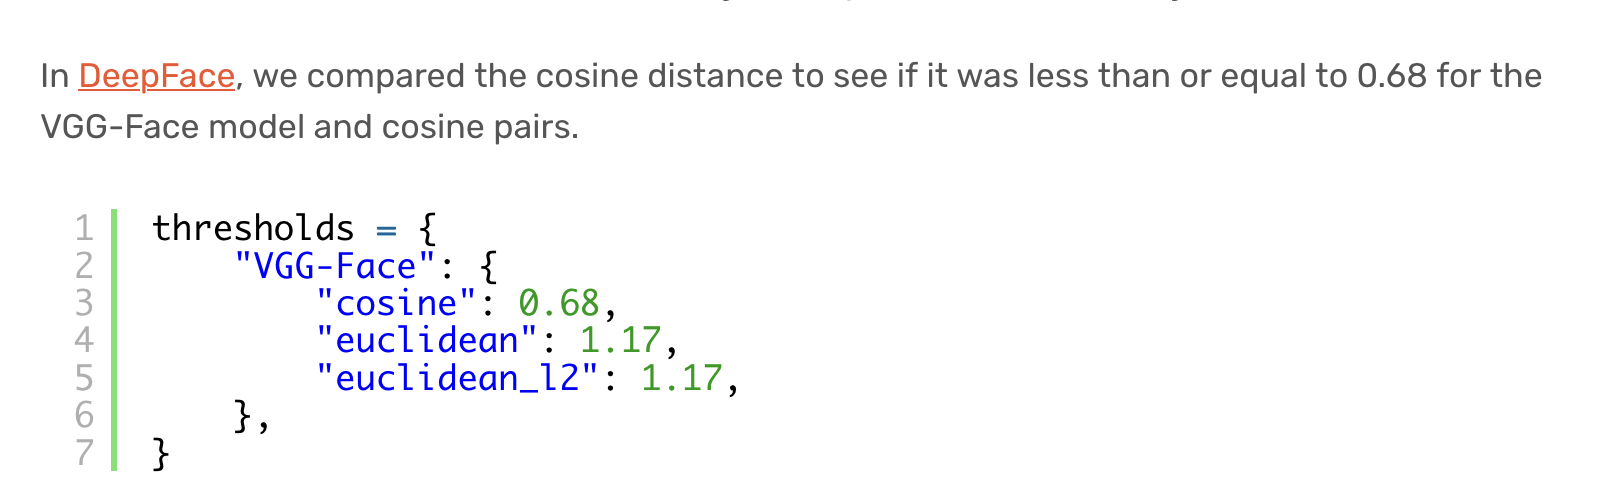

In [ ]:
threshold = 0.32 # 1 - 0.68 from Deepface

print(f"Threshold for matching: {threshold}")

print(f"Ethel and Ethel: {'MATCH' if sim_e1_e2 >= threshold else 'NO MATCH'} (score: {sim_e1_e2:.4f})")
print(f"Ethel vs Lana: {'MATCH' if sim_e1_l >= threshold else 'NO MATCH'} (score: {sim_e1_l:.4f})")


Threshold for matching: 0.32
Ethel and Ethel: MATCH (score: 0.4012)
Ethel vs Lana: NO MATCH (score: 0.0740)


: 

This is a good thing lol, they match

25-07-21 21:52:16 - public key is restored from keys/paillier_public_key.txt
25-07-21 21:52:16 - private-public key pair is restored from keys/paillier_private_key.txt
Initializing webcam...
Capturing in 3 seconds... Look at the camera
3...
2...
1...
Smile!
Image saved to test_images/webcam_capture.jpg

Processing your face image...


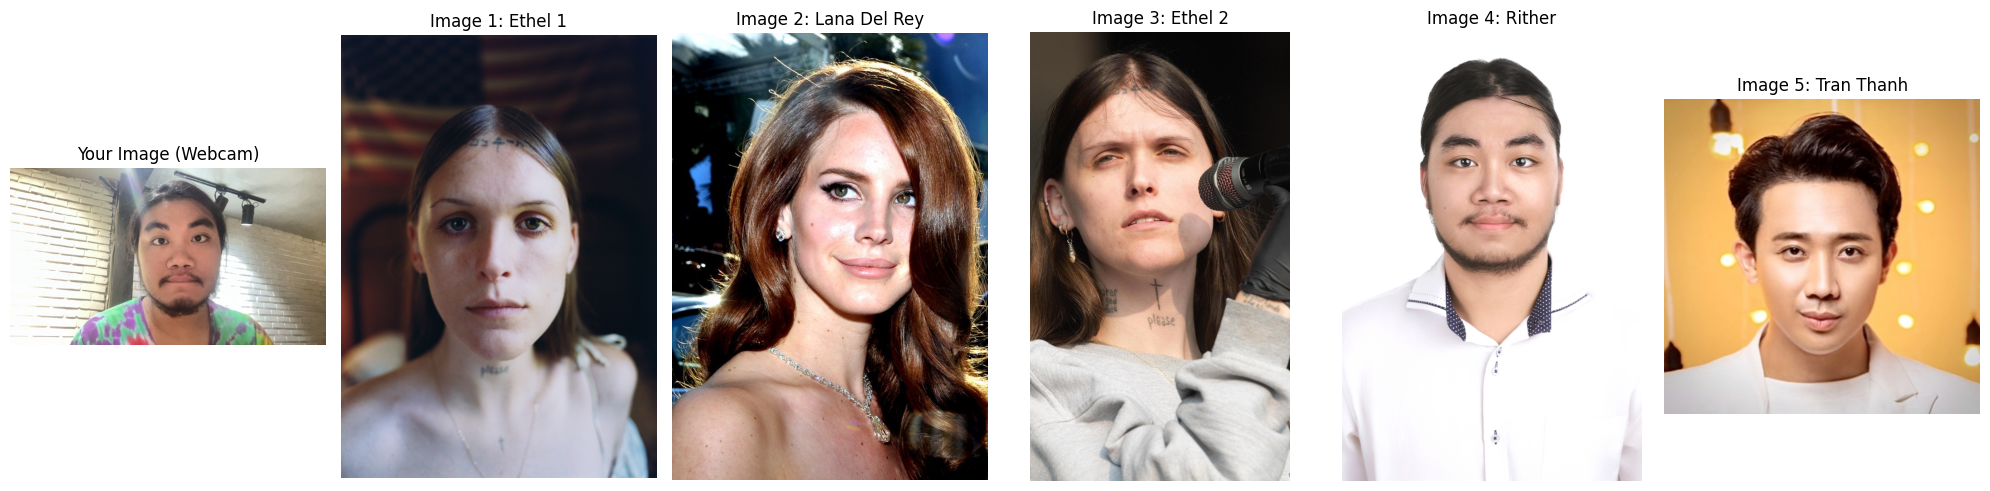


Extracting face embeddings...


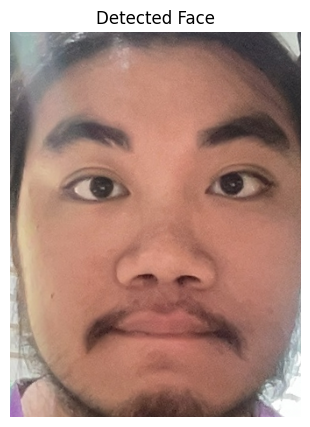

Face embedding extracted. Shape: (4096,)

Encrypting your face embedding...


Encrypting tensors: 100%|██████████| 4096/4096 [00:02<00:00, 1905.06it/s]


Encryption complete!

Comparing with reference faces...
Similarity with Ethel 1: 0.0337
Similarity with Lana Del Rey: 0.0618
Similarity with Ethel 2: 0.0284
Similarity with Rither: 0.4542
Similarity with Tran Thanh: 0.1626

Using threshold: 0.32

Match Results:
You and Ethel 1: NO MATCH (score: 0.0337)
You and Lana Del Rey: NO MATCH (score: 0.0618)
You and Ethel 2: NO MATCH (score: 0.0284)
You and Rither: MATCH (score: 0.4542)
You and Tran Thanh: NO MATCH (score: 0.1626)


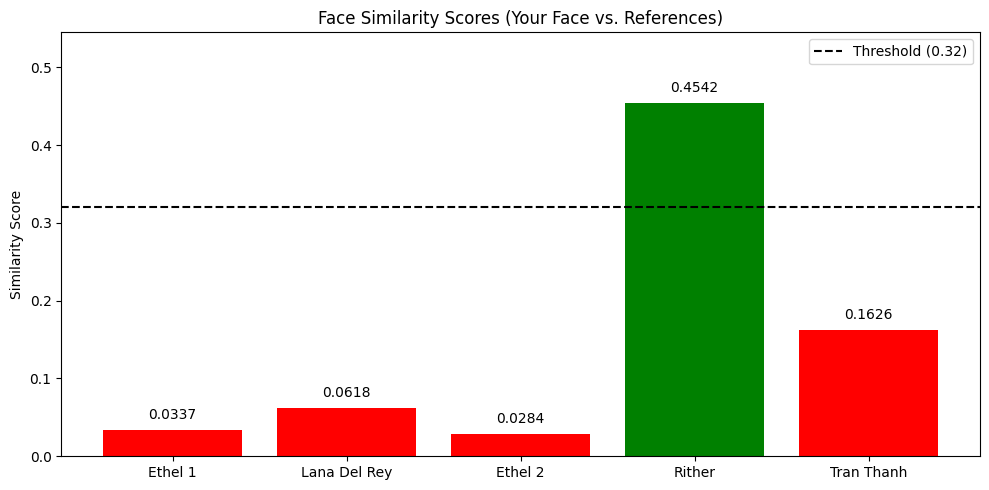

: 

In [ ]:
import cv2
import time
import os
from tqdm import tqdm
import threading
import matplotlib.pyplot as plt

from PIL import Image
public_key_path = "keys/paillier_public_key.txt"
private_key_path = "keys/paillier_private_key.txt"

server_cs = LightPHE(algorithm_name="Paillier", precision=14, key_file=public_key_path)
client_cs = LightPHE(algorithm_name="Paillier", precision=14, key_file=private_key_path)


def capture_from_webcam():
    """Capture an image from webcam and save it to test_images folder without text overlay"""
    # Initialize webcam
    print("Initializing webcam...")
    cap = cv2.VideoCapture(0)  
    
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return None
    
    # Create preview window
    cv2.namedWindow("Webcam Preview", cv2.WINDOW_NORMAL)
    
    # Wait for camera to initialize
    time.sleep(1)
    
    countdown_seconds = 3
    captured_frame = None
    
    print(f"Capturing in {countdown_seconds} seconds... Look at the camera")
    
    # Countdown loop
    for i in range(countdown_seconds, 0, -1):
        print(f"{i}...")
        
        # Capture frames during countdown
        for _ in range(10):  # Show multiple frames during each countdown second
            ret, frame = cap.read()
            if not ret:
                print("Error: Failed to capture frame.")
                cap.release()
                cv2.destroyAllWindows()
                return None
                
            # Display countdown on frame - but don't modify the original frame
            display_frame = frame.copy()
            cv2.putText(display_frame, str(i), (display_frame.shape[1]//2 - 50, display_frame.shape[0]//2 + 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 4)
            cv2.imshow("Webcam Preview", display_frame)
            cv2.waitKey(100)  # Small delay
    
    # Capture the final frame
    print("Smile!")
    ret, frame = cap.read()
    
    if ret:
        captured_frame = frame.copy()  # Store the clean frame without any text
        
        # Show "Captured!" message on display frame only
        display_frame = frame.copy()
        cv2.putText(display_frame, "Captured!", (display_frame.shape[1]//2 - 100, display_frame.shape[0]//2 + 50), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2)
        cv2.imshow("Webcam Preview", display_frame)
        cv2.waitKey(1000)  # Show for 1 second
        
        # Save the clean image without any text
        img_path = os.path.join("test_images", "webcam_capture.jpg")
        cv2.imwrite(img_path, captured_frame)
        print(f"Image saved to {img_path}")
    else:
        print("Error: Failed to capture frame.")
    
    # Release resources
    cap.release()
    cv2.destroyAllWindows()
    
    return img_path if captured_frame is not None else None


# Capture image from webcam
webcam_img_path = capture_from_webcam()

if webcam_img_path is not None:
    print("\nProcessing your face image...")
    
    reference_images = ["img1.jpg", "img2.jpg", "img3.jpg", "portrait.JPG", "tranthanh.jpg"]
    
    for img_file in reference_images:
        if not os.path.exists(os.path.join("test_images", img_file)):
            print(f"Reference image {img_file} not found. Running download function...")
            download_sample_images()
            break

    fig, axes = plt.subplots(1, 6, figsize=(20, 5))
    
    img = Image.open(webcam_img_path)
    axes[0].imshow(img)
    axes[0].set_title("Your Image (Webcam)")
    axes[0].axis('off')

    ref_names = ["Ethel 1", "Lana Del Rey", "Ethel 2", "Rither", "Tran Thanh"]

    for i, img_file in enumerate(reference_images):
        img_path = os.path.join("test_images", img_file)
        img = Image.open(img_path)
        axes[i+1].imshow(img)
        
        axes[i+1].set_title(f"Image {i+1}: {ref_names[i]}")
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    try:
        print("\nExtracting face embeddings...")
        
        webcam_faces = DeepFace.extract_faces(webcam_img_path, detector_backend="yunet", enforce_detection=True)
        
        if len(webcam_faces) == 0:
            print("No face detected in your webcam image!")
        else:
            fig, ax = plt.subplots(1, 1, figsize=(5, 5))
            face_img = webcam_faces[0]['face']
            face_img_uint8 = (face_img * 255).astype("uint8") if face_img.dtype != "uint8" else face_img
            # face_img_rgb = cv2.cvtColor(face_img_uint8, cv2.COLOR_BGR2RGB)
            ax.imshow(face_img_uint8)
            ax.set_title("Detected Face")
            ax.axis('off')
            plt.show()
        

        my_embedding = DeepFace.represent(webcam_img_path, model_name="VGG-Face", detector_backend="yunet")[0]["embedding"]

        ref_embeddings = []
        ref_names = ["Ethel 1", "Lana Del Rey", "Ethel 2", "Rither", "Tran Thanh"]
        
        for i, img_file in enumerate(reference_images):
            img_path = os.path.join("test_images", img_file)
            embedding = DeepFace.represent(img_path, model_name="VGG-Face", detector_backend="yunet")[0]["embedding"]
            ref_embeddings.append((ref_names[i], embedding))
        
        print(f"Face embedding extracted. Shape: {np.array(my_embedding).shape}")
        
        print("\nEncrypting your face embedding...")
        my_encrypted = server_cs.encrypt(my_embedding)
        print("Encryption complete!")
        
        print("\nComparing with reference faces...")
        results = []
        
        for name, ref_embedding in ref_embeddings:
            if isinstance(ref_embedding, np.ndarray):
                ref_embedding_list = ref_embedding.tolist()
            else:
                ref_embedding_list = ref_embedding
            
            encrypted_sim = my_encrypted @ ref_embedding_list
            
            decrypted_sim = client_cs.decrypt(encrypted_sim)[0]
            
            expected_sim = sum(x * y for x, y in zip(my_embedding, ref_embedding))
            
            # Store results
            results.append({
                "name": name,
                "encrypted_similarity": decrypted_sim,
                "plaintext_similarity": expected_sim,
                "error": abs(decrypted_sim - expected_sim)
            })
            
            print(f"Similarity with {name}: {decrypted_sim:.4f}")        
        # Show match results
        threshold = 0.32  # 1 - 0.68 from DeepFace
        
        print(f"\nUsing threshold: {threshold}")
        print("\nMatch Results:")
        
        for result in results:
            match_status = "MATCH" if result["encrypted_similarity"] >= threshold else "NO MATCH"
            print(f"You and {result['name']}: {match_status} (score: {result['encrypted_similarity']:.4f})")
        
        # Visualize results
        names = [r["name"] for r in results]
        scores = [r["encrypted_similarity"] for r in results]
        
        plt.figure(figsize=(10, 5))
        bars = plt.bar(names, scores, color=['green' if s >= threshold else 'red' for s in scores])
        plt.axhline(y=threshold, color='black', linestyle='--', label=f'Threshold ({threshold})')
        
        plt.title('Face Similarity Scores (Your Face vs. References)')
        plt.ylabel('Similarity Score')
        plt.ylim(0, max(scores) * 1.2)
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.4f}', ha='center', va='bottom')
        
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error processing face embedding: {str(e)}")

else:
    print("Failed to capture image from webcam.")

# Testing with tenseal (FHE)

In [ ]:
import tenseal as ts
import time
import numpy as np
from sklearn.preprocessing import normalize

# Create a TenSEAL comparison framework
print("Setting up TenSEAL (FHE) for comparison...")

def setup_tenseal():
    # TenSEAL context setup with CKKS
    context_params = ts.context_parameter(
        scheme_type=ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=8192,
        coeff_mod_bit_sizes=[60, 40, 40, 60]
    )
    context = ts.context(context_params)
    context.generate_galois_keys()
    context.global_scale = 2**40
    return context

# Setup CKKS context for vector operations
context = setup_tenseal()